<a href="https://colab.research.google.com/github/Niharika0804/Multimodal_TCGA-LUAD/blob/main/_main_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pydicom pillow
!pip install -U cupy-cuda12x
import os
import pydicom
import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm
import shutil
import glob
from collections import Counter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 MB 7.2 MB/s eta 0:00:00
  Attempting uninstall: cupy-cuda12x
    Found existing installation: cupy-cuda12x 13.3.0
    Uninstalling cupy-cuda12x-13.3.0:
      Successfully uninstalled cupy-cuda12x-13.3.0


In [ ]:
cp -r "/content/drive/MyDrive/BioInformatics/Organized_dataset" /content/

In [ ]:
import cupy as cp
# Define paths
input_dir = "/content/Organized_dataset"
output_dir = "/content/Normalizedf_dataset"
os.makedirs(output_dir, exist_ok=True)

# Get all image paths
image_files = glob.glob(os.path.join(input_dir, "**", "*.png"), recursive=True)

# Batch size (adjust based on available GPU memory)
BATCH_SIZE = 64

# Determine a fixed size (e.g., max width & height in dataset)
TARGET_SIZE = (256, 256)  # Resize all images to 256x256

def process_batch(batch_files):
    batch_imgs = []
    output_paths = []

    # Load and resize batch of images
    for img_path in batch_files:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Skipping: {img_path}")
            continue

        img_resized = cv2.resize(img, TARGET_SIZE, interpolation=cv2.INTER_AREA)
        batch_imgs.append(img_resized)
        output_paths.append(img_path)

    if not batch_imgs:
        return  # Skip if no valid images in batch

    # Convert to GPU tensor
    batch_gpu = cp.array(batch_imgs, dtype=cp.float32)

    # Min-Max Normalization on GPU
    min_vals = batch_gpu.min(axis=(1, 2), keepdims=True)
    max_vals = batch_gpu.max(axis=(1, 2), keepdims=True)
    batch_gpu = (batch_gpu - min_vals) / (max_vals - min_vals + 1e-8)

    # Scale back to 8-bit (0-255)
    batch_gpu = (batch_gpu * 255).astype(cp.uint8)

    # Convert back to CPU
    batch_normalized = cp.asnumpy(batch_gpu)

    # Save batch
    for img_normalized, img_path in zip(batch_normalized, output_paths):
        relative_path = os.path.relpath(img_path, input_dir)
        output_path = os.path.join(output_dir, relative_path)
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        cv2.imwrite(output_path, img_normalized)

# Process images in batches
for i in tqdm(range(0, len(image_files), BATCH_SIZE), desc="Processing Batches on GPU"):
    batch_files = image_files[i : i + BATCH_SIZE]
    process_batch(batch_files)

print("✅ GPU-accelerated batch processing complete! Images saved in:", output_dir)


Processing Batches on GPU:  66%|██████▋   | 507/765 [02:34<00:57,  4.47it/s]

Skipping: /content/Organized_dataset/TCGA-17-Z060/4-003.png


Processing Batches on GPU:  67%|██████▋   | 511/765 [02:35<00:59,  4.23it/s]

Skipping: /content/Organized_dataset/TCGA-17-Z060/1-200.png


Processing Batches on GPU: 100%|██████████| 765/765 [03:55<00:00,  3.24it/s]

✅ GPU-accelerated batch processing complete! Images saved in: /content/Normalizedf_dataset


In [ ]:
import glob

# Path to normalized images
normalized_images = glob.glob("/content/drive/MyDrive/BioInformatics/Normalized_final/Normalizedf_dataset/**/*.png", recursive=True)

# Print the count
print(f"✅ Total normalized images: {len(normalized_images)}")


✅ Total normalized images: 48945


In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!export LC_ALL=C.UTF-8 && export LANG=C.UTF-8

In [ ]:
!cp -r "/content/Normalizedf_dataset" "/content/drive/MyDrive/BioInformatics/Normalized_final/"


In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image

img_path = "/content/Normalizedf_dataset/TCGA-17-Z011/1-01.png"  # Change to any sample image
img = Image.open(img_path).convert("RGB")

# Load without normalization
transform_no_norm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

tensor_no_norm = transform_no_norm(img)
print("Min:", torch.min(tensor_no_norm), "Max:", torch.max(tensor_no_norm))


Min: tensor(0.) Max: tensor(0.9098)


In [ ]:
from transformers import AutoImageProcessor, ResNetForImageClassification
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.patient_ids = []

        # Recursively collect image paths & patient IDs
        for patient_folder in os.listdir(root_dir):
            patient_path = os.path.join(root_dir, patient_folder)
            if os.path.isdir(patient_path):  # Ensure it's a directory
                for img_name in os.listdir(patient_path):
                    img_path = os.path.join(patient_path, img_name)
                    if img_path.endswith((".png", ".jpg", ".jpeg")):
                        self.image_paths.append(img_path)
                        self.patient_ids.append(patient_folder)  # Store patient ID

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        patient_id = self.patient_ids[idx]  # Get corresponding patient ID
        image = Image.open(img_path).convert("RGB")  # Ensure RGB

        if self.transform:
            image = self.transform(image)

        return image, patient_id  # Return both image & patient ID

# Load dataset
dataset = CustomImageDataset(root_dir="/content/Normalizedf_dataset", transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
import torch
import torchvision.models as models
import pandas as pd

# Load pre-trained ResNet-50
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove FC layer
model.eval()  # Set to evaluation mode

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Extract & store features
image_features = []
patient_ids = []

with torch.no_grad():
    for images, patient_batch in dataloader:
        images = images.to(device)
        features = model(images)  # Extract features
        features = features.view(features.size(0), -1)  # Flatten

        image_features.append(features.cpu())
        patient_ids.extend(patient_batch)  # Store patient IDs

# Convert to tensors & save
image_features = torch.cat(image_features, dim=0).numpy()

# Save as CSV (PatientID, Feature1, Feature2, ..., Feature2048)
df = pd.DataFrame(image_features)
df.insert(0, "PatientID", patient_ids)  # Insert Patient ID as first column
df.to_csv("resnet_features.csv", index=False)

print("Feature extraction complete! Saved as 'resnet_features.csv'")


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 58.9MB/s]


Feature extraction complete! Saved as 'resnet_features.csv'


In [ ]:
!cp -r "/content/resnet_features.csv" "/content/drive/MyDrive/BioInformatics/"


In [ ]:
!cp -r "/content/drive/MyDrive/BioInformatics/resnet_features.csv" /content/

In [ ]:
!cp -r "/content/drive/MyDrive/BioInformatics/biospecimen.project-tcga-luad.2025-03-05.json" /content/

In [ ]:
!cp -r "/content/drive/MyDrive/BioInformatics/clinical.project-tcga-luad.2025-03-05.json" /content/

In [ ]:
# Load clinical data
import pandas as pd
df_clinical = pd.read_json("clinical.project-tcga-luad.2025-03-05.json")

# Load biomedical data
df_biomedical = pd.read_json("biospecimen.project-tcga-luad.2025-03-05.json")

print("Clinical Columns:", df_clinical.columns)
print("Biomedical Columns:", df_biomedical.columns)
print("Clinical Shape:", df_clinical.shape)
print("Biomedical Shape:", df_biomedical.shape)


# Load extracted image features
df_image_features = pd.read_csv("resnet_features.csv")
print("image_features_columns:", df_image_features.columns)
print("image_features:", df_image_features.shape)

Clinical Columns: Index(['exposures', 'case_id', 'follow_ups', 'project', 'submitter_id',
       'diagnoses', 'demographic'],
      dtype='object')
Biomedical Columns: Index(['case_id', 'project', 'submitter_id', 'samples'], dtype='object')
Clinical Shape: (585, 7)
Biomedical Shape: (585, 4)
image_features_columns: Index(['PatientID', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '2038', '2039', '2040', '2041', '2042', '2043', '2044', '2045', '2046',
       '2047'],
      dtype='object', length=2049)
image_features: (48945, 2049)


In [ ]:
df_image_features.rename(columns={"PatientID": "submitter_id"}, inplace=True)
print("image_features_columns:", df_image_features.columns)

image_features_columns: Index(['submitter_id', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '2038', '2039', '2040', '2041', '2042', '2043', '2044', '2045', '2046',
       '2047'],
      dtype='object', length=2049)


In [ ]:
import pandas as pd
import json

# Load the JSON data from the file
file_path = "/content/drive/MyDrive/ML_Project/BioInformatics/clinical.project-tcga-luad.2025-03-05.json"
with open(file_path, 'r') as f:
    clinical_data_list = json.load(f)

# Convert the list of dictionaries to a Pandas DataFrame for filtering
df_clinical = pd.DataFrame(clinical_data_list)

# List of valid patient IDs
valid_patients = ['TCGA-17-Z051', 'TCGA-17-Z028', 'TCGA-17-Z020', 'TCGA-50-5045',
                  'TCGA-50-5072', 'TCGA-50-6592', 'TCGA-17-Z011', 'TCGA-17-Z048',
                  'TCGA-17-Z053', 'TCGA-50-6673', 'TCGA-50-6590', 'TCGA-50-6595',
                  'TCGA-50-5942', 'TCGA-17-Z060', 'TCGA-38-6178', 'TCGA-50-5051',
                  'TCGA-17-Z050', 'TCGA-J2-A4AD', 'TCGA-17-Z030', 'TCGA-50-6593',
                  'TCGA-50-5049', 'TCGA-17-Z059', 'TCGA-50-8459', 'TCGA-17-Z062',
                  'TCGA-17-Z031', 'TCGA-38-A44F', 'TCGA-17-Z058', 'TCGA-50-6591',
                  'TCGA-17-Z021', 'TCGA-50-5066', 'TCGA-J2-A4AE', 'TCGA-17-Z035',
                  'TCGA-38-4625', 'TCGA-50-8460', 'TCGA-50-5941', 'TCGA-50-5936',
                  'TCGA-50-6594', 'TCGA-17-Z034', 'TCGA-38-4629', 'TCGA-17-Z043',
                  'TCGA-50-5055', 'TCGA-J2-8192', 'TCGA-17-Z045', 'TCGA-17-Z023',
                  'TCGA-17-Z015', 'TCGA-17-Z029', 'TCGA-17-Z054', 'TCGA-17-Z052',
                  'TCGA-50-5044', 'TCGA-J2-A4AG', 'TCGA-38-4628', 'TCGA-50-5946',
                  'TCGA-17-Z019', 'TCGA-17-Z056', 'TCGA-17-Z042', 'TCGA-38-4626',
                  'TCGA-17-Z032', 'TCGA-17-Z061', 'TCGA-17-Z027', 'TCGA-17-Z039',
                  'TCGA-17-Z038', 'TCGA-17-Z018', 'TCGA-17-Z016', 'TCGA-17-Z013',
                  'TCGA-17-Z036', 'TCGA-17-Z017', 'TCGA-17-Z033', 'TCGA-17-Z024',
                  'TCGA-J2-8194']

# Filter the clinical DataFrame
df_clinical_filtered = df_clinical[df_clinical['submitter_id'].isin(valid_patients)]

all_flattened_data = []

# Iterate through the *filtered* DataFrame
for index, row in df_clinical_filtered.iterrows():
    flattened_data = {}
    case_data = row.to_dict()

    # Top-level information
    flattened_data['case_id'] = case_data.get('case_id')
    flattened_data['submitter_id'] = case_data.get('submitter_id')

    # Process Exposures
    if isinstance(case_data.get('exposures'), list) and case_data['exposures']:
        exposure = case_data['exposures'][0]
        flattened_data['tobacco_smoking_quit_year'] = exposure.get('tobacco_smoking_quit_year')
        flattened_data['tobacco_smoking_status'] = exposure.get('tobacco_smoking_status')
        flattened_data['pack_years_smoked'] = exposure.get('pack_years_smoked')
    else:
        flattened_data['tobacco_smoking_quit_year'] = None
        flattened_data['tobacco_smoking_status'] = None
        flattened_data['pack_years_smoked'] = None

    # Process Diagnosis
    if isinstance(case_data.get('diagnoses'), list) and case_data['diagnoses']:
        diagnosis = case_data['diagnoses'][0]
        flattened_data['ajcc_pathologic_stage'] = diagnosis.get('ajcc_pathologic_stage')
        flattened_data['days_to_diagnosis'] = diagnosis.get('days_to_diagnosis')
        flattened_data['laterality'] = diagnosis.get('laterality')
        flattened_data['tissue_or_organ_of_origin'] = diagnosis.get('tissue_or_organ_of_origin')
        flattened_data['age_at_diagnosis_days'] = diagnosis.get('age_at_diagnosis')
        flattened_data['primary_diagnosis'] = diagnosis.get('primary_diagnosis')
        flattened_data['year_of_diagnosis'] = diagnosis.get('year_of_diagnosis')
        flattened_data['prior_malignancy'] = diagnosis.get('prior_malignancy')
        flattened_data['ajcc_pathologic_t'] = diagnosis.get('ajcc_pathologic_t')
        flattened_data['ajcc_pathologic_n'] = diagnosis.get('ajcc_pathologic_n')
        flattened_data['ajcc_pathologic_m'] = diagnosis.get('ajcc_pathologic_m')
        flattened_data['morphology'] = diagnosis.get('morphology')
        flattened_data['residual_disease'] = diagnosis.get('residual_disease')
        flattened_data['icd_10_code'] = diagnosis.get('icd_10_code')
    else:
        for key in ['ajcc_pathologic_stage', 'days_to_diagnosis', 'laterality',
                    'tissue_or_organ_of_origin', 'age_at_diagnosis_days', 'primary_diagnosis',
                    'year_of_diagnosis', 'prior_malignancy', 'ajcc_pathologic_t',
                    'ajcc_pathologic_n', 'ajcc_pathologic_m', 'morphology',
                    'residual_disease', 'icd_10_code']:
            flattened_data[key] = None

    # Process Treatments
    diagnoses = case_data.get('diagnoses')
    treatments = []
    if isinstance(diagnoses, list) and diagnoses:  # Check if it's a non-empty list
        treatments = diagnoses[0].get('treatments', [])
    chemotherapy = False
    radiation_therapy = False
    therapeutic_agents = set()

    for treatment in treatments:
        if treatment.get('treatment_type') == 'Chemotherapy':
            chemotherapy = True
            if treatment.get('therapeutic_agents'):
                agents = treatment.get('therapeutic_agents')
                if isinstance(agents, str):
                    therapeutic_agents.add(agents)
                elif isinstance(agents, list):
                    therapeutic_agents.update(agents)
        elif treatment.get('treatment_type') == 'Radiation Therapy, NOS':
            radiation_therapy = True

    flattened_data['received_chemotherapy'] = chemotherapy
    flattened_data['received_radiation_therapy'] = radiation_therapy
    flattened_data['therapeutic_agents'] = ", ".join(therapeutic_agents) if therapeutic_agents else None

    # Process Follow-ups
    last_contact_follow_up = None
    follow_ups_data = case_data.get('follow_ups')
    if isinstance(follow_ups_data, (list, tuple)):
      for fu in follow_ups_data:
          if fu.get('timepoint_category') == 'Last Contact':
              last_contact_follow_up = fu
              break

    if last_contact_follow_up:
        flattened_data['last_contact_days_to_follow_up'] = last_contact_follow_up.get('days_to_follow_up')
        flattened_data['last_contact_disease_response'] = last_contact_follow_up.get('disease_response')
    else:
        flattened_data['last_contact_days_to_follow_up'] = None
        flattened_data['last_contact_disease_response'] = None

    # Process Demographic Information
    demographic = case_data.get('demographic', {})
    if isinstance(demographic, dict):  # Add this check
      flattened_data['ethnicity'] = demographic.get('ethnicity')
      flattened_data['gender'] = demographic.get('gender')
      flattened_data['race'] = demographic.get('race')
      flattened_data['vital_status'] = demographic.get('vital_status')
      flattened_data['age_at_index'] = demographic.get('age_at_index')
      flattened_data['days_to_birth'] = demographic.get('days_to_birth')
      flattened_data['country_of_residence_at_enrollment'] = demographic.get('country_of_residence_at_enrollment')
    else:
        # Handle cases where 'demographic' is not a dictionary (e.g., set to None)
        flattened_data['ethnicity'] = None
        flattened_data['gender'] = None
        flattened_data['race'] = None
        flattened_data['vital_status'] = None
        flattened_data['age_at_index'] = None
        flattened_data['days_to_birth'] = None
        flattened_data['country_of_residence_at_enrollment'] = None

    all_flattened_data.append(flattened_data)

# Create a Pandas DataFrame from the list of flattened data
df_clinical_flattened = pd.DataFrame(all_flattened_data)

print((df_clinical_flattened["last_contact_disease_response"]))
print(f"\nShape of the flattened DataFrame: {df_clinical_flattened.shape}")

0              None
1     WT-With Tumor
2     WT-With Tumor
3              None
4     TF-Tumor Free
          ...      
64             None
65             None
66    WT-With Tumor
67             None
68             None
Name: last_contact_disease_response, Length: 69, dtype: object

Shape of the flattened DataFrame: (69, 31)


Value counts of the target variable:
target
1.0    16
0.0    15
Name: count, dtype: int64

First few rows with the 'target' variable:
   submitter_id vital_status  target
1  TCGA-J2-A4AD         Dead     1.0
2  TCGA-50-6592         Dead     1.0
3  TCGA-38-4625        Alive     0.0
4  TCGA-50-6590         Dead     1.0
5  TCGA-38-4629         Dead     1.0

Shape of X_train: (24, 29)
Shape of X_val: (7, 29)
Shape of y_train: (24,)
Shape of y_val: (7,)

Correlation of features in the training set with the target variable:
vital_status                          1.000000e+00
target                                1.000000e+00
pack_years_smoked                     5.425460e-01
last_contact_disease_response         4.335147e-01
therapeutic_agents                    9.065968e-02
primary_diagnosis                     6.579517e-02
days_to_birth                         4.549035e-02
tobacco_smoking_quit_year             4.496119e-02
ajcc_pathologic_stage                 4.454354e-02
ajcc_pathologic_n

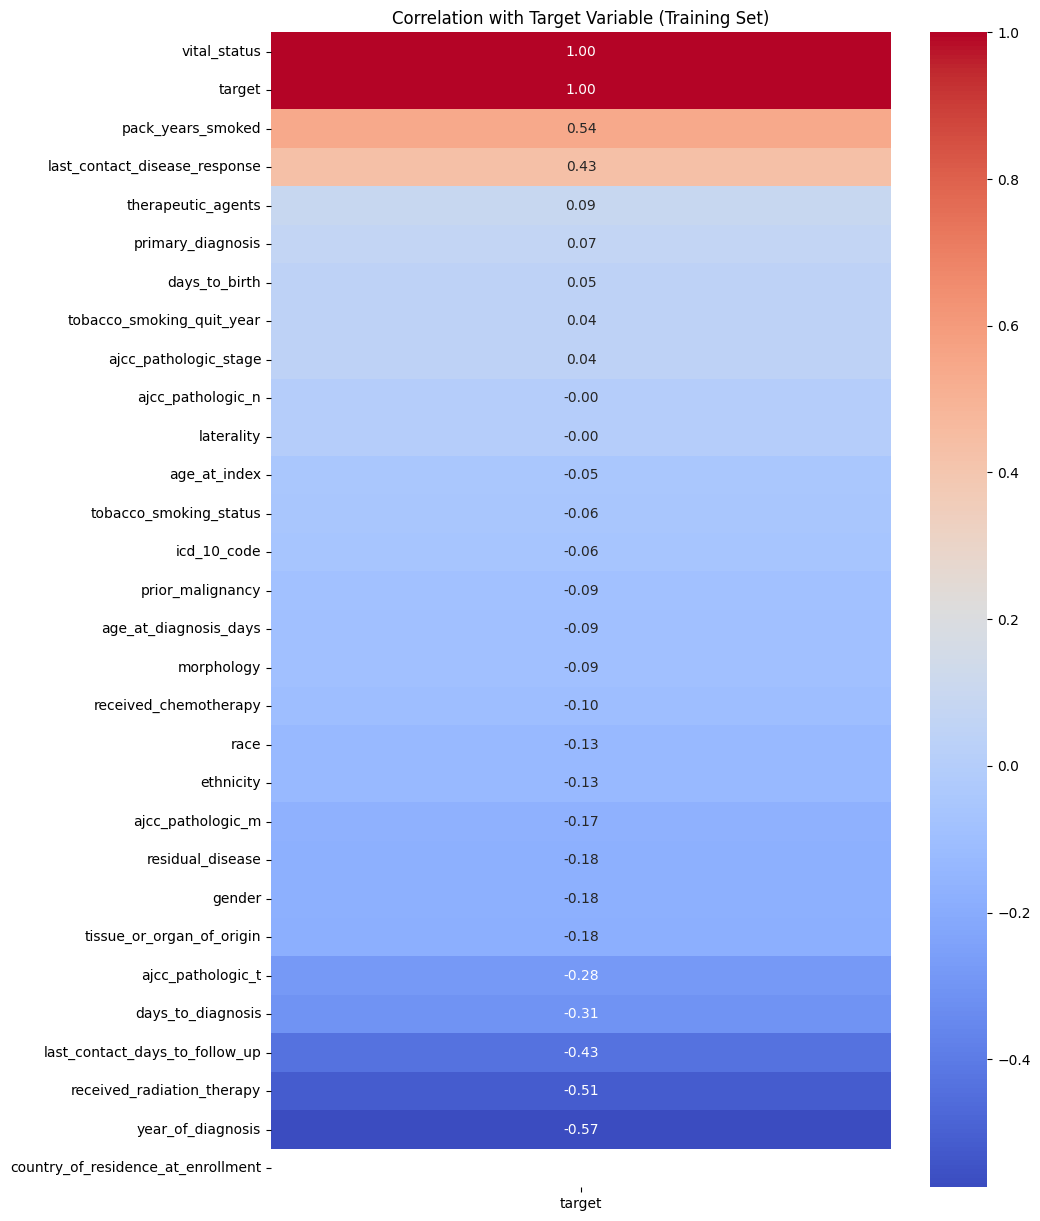

In [ ]:
# #correlation analysis of target variable
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder  # Import LabelEncoder

# # 2. Create the target variable
# def create_target(response):
#     if response == 'Alive':
#         return 0  # Assuming 'Tumor Free' is a negative outcome (no disease progression)
#     elif response == 'Dead':
#         return 1  # Assuming 'With Tumor' is a positive outcome (disease progression or persistence)
#     else:
#         return None # Handle other responses if they exist

# df_clinical_flattened['target'] = df_clinical_flattened['vital_status'].apply(create_target)

# # Before dropping rows, check if any rows have a target value
# # --- Changed to allow data splitting with potential NaNs ---
# if df_clinical_flattened['target'].notna().any():
#     df_clinical_flattened.dropna(subset=['target'], inplace=True) # Remove rows where target is NaN for correlation analysis
# else:
#     print("Warning: No non-NaN values in 'target' column. Data splitting might produce empty sets.")

# # Print Value counts and first few rows if there are non-NaN values in 'target'
# if df_clinical_flattened['target'].notna().any():
#     print("Value counts of the target variable:")
#     print(df_clinical_flattened['target'].value_counts())
#     print("\nFirst few rows with the 'target' variable:")
#     print(df_clinical_flattened[['submitter_id', 'vital_status', 'target']].head())

# # 3. Split the data
# # --- Moved outside the if condition to always create train/val sets ---
# X = df_clinical_flattened.drop(columns=['target', 'case_id', 'submitter_id'])
# y = df_clinical_flattened['target']
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# # --- Encode categorical features in X_train ---
# # Create a LabelEncoder object
# le = LabelEncoder()

# # Fit and transform the encoder on each categorical column
# for col in X_train.select_dtypes(include=['object']).columns:
#     X_train[col] = le.fit_transform(X_train[col])

# # --- Print shapes after data splitting ---
# print("\nShape of X_train:", X_train.shape)
# print("Shape of X_val:", X_val.shape)
# print("Shape of y_train:", y_train.shape)
# print("Shape of y_val:", y_val.shape)

# # 4. Correlation Analysis on the training data
# # Combine training features and target for correlation calculation
# # --- Only perform correlation analysis if X_train is not empty ---
# if not X_train.empty:
#     train_df = pd.concat([X_train, y_train], axis=1)

#     # Calculate the correlation matrix with the 'target' variable
#     correlations = train_df.corr()['target'].sort_values(ascending=False)

#     print("\nCorrelation of features in the training set with the target variable:")
#     print(correlations)

#     # Identify highly correlated features (adjust threshold as needed)
#     high_correlation_threshold = 0.8
#     highly_correlated_features = correlations[abs(correlations) > high_correlation_threshold]

#     print("\nFeatures in the training set with high correlation to the target:")
#     print(highly_correlated_features)

#     # Optional: Visualize the correlations (if you have a manageable number of features)
#     import matplotlib.pyplot as plt
#     import seaborn as sns

#     plt.figure(figsize=(10, 15))
#     sns.heatmap(train_df.corr()[['target']].sort_values(by='target', ascending=False),
#                 annot=True, cmap='coolwarm', fmt=".2f")
#     plt.title('Correlation with Target Variable (Training Set)')
#     plt.show()
# else:
#     print("\nWarning: X_train is empty. Correlation analysis skipped.")

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import StandardScaler

# df_clinical_encoded = pd.DataFrame(df_flattened)

# # --- Corrected Handling of Missing Values ---
# numerical_cols = df_clinical_encoded.select_dtypes(include=np.number).columns
# for col in numerical_cols:
#     df_clinical_encoded.loc[:, col] = df_clinical_encoded[col].fillna(df_clinical_encoded[col].median())

# categorical_cols = df_clinical_encoded.select_dtypes(include='object').columns
# for col in categorical_cols:
#     df_clinical_encoded.loc[:, col] = df_clinical_encoded[col].fillna(df_clinical_encoded[col].mode()[0])

# # # --- Encoding Categorical Features (excluding identifiers) ---
# # categorical_cols_to_encode = [col for col in df_clinical_encoded.select_dtypes(include='object').columns
# #                              if col not in ['case_id', 'submitter_id']]
# # df_clinical_encoded = pd.get_dummies(df_clinical_encoded, columns=categorical_cols_to_encode, drop_first=True)

# # # --- Feature Scaling ---
# # numerical_cols_to_scale = df_clinical_encoded.select_dtypes(include=np.number).columns.tolist()
# # if 'case_id' in numerical_cols_to_scale:
# #     numerical_cols_to_scale.remove('case_id')
# # if 'submitter_id' in numerical_cols_to_scale:
# #     numerical_cols_to_scale.remove('submitter_id')

# # scaler = StandardScaler()
# # if numerical_cols_to_scale:  # Ensure there are numerical columns to scale
# #     df_clinical_encoded.loc[:, numerical_cols_to_scale] = scaler.fit_transform(df_clinical_encoded[numerical_cols_to_scale])

# print("DataFrame after preprocessing (with case_id and submitter_id):")
# print(df_clinical_encoded.head(1))
# print(df_clinical_encoded["submitter_id"])
# print(f"\nShape of the preprocessed DataFrame: {df_clinical_encoded.shape}")
# print("\nNumber of missing values after preprocessing:")
# print(df_clinical_encoded.isnull().sum().sum())

DataFrame after preprocessing (with case_id and submitter_id):
                                case_id  submitter_id  \
0  0147edcf-0ca5-4136-bd01-43d05e2843f4  TCGA-17-Z038   

   tobacco_smoking_quit_year                     tobacco_smoking_status  \
0                     1998.0  Current Reformed Smoker for < or = 15 yrs   

   pack_years_smoked ajcc_pathologic_stage  days_to_diagnosis laterality  \
0               30.0              Stage IB                0.0      Right   

  tissue_or_organ_of_origin  age_at_diagnosis_days  ...  \
0          Upper lobe, lung                25525.5  ...   

        therapeutic_agents  last_contact_days_to_follow_up  \
0  Carboplatin, Paclitaxel                           829.0   

  last_contact_disease_response               ethnicity  gender   race  \
0                 WT-With Tumor  not hispanic or latino  female  white   

  vital_status age_at_index days_to_birth  country_of_residence_at_enrollment  
0         Dead         68.0      -25104.0    

In [ ]:
# from google.colab import drive
# file_path = "/content/drive/MyDrive/ML_Project/BioInformatics/cleaned_clinical_data.csv"

# # Save DataFrame to CSV
# df_clinical_encoded.to_csv(file_path, index=False)
# print(df_clinical_encoded.shape)

# print(f"File saved at: {file_path}")

(69, 31)
File saved at: /content/drive/MyDrive/ML_Project/BioInformatics/cleaned_clinical_data.csv


In [ ]:
# #print(df_clinical_encoded['last_contact_disease_response_WT-With Tumor'])
# print((df_clinical_encoded['last_contact_disease_response']))

0     WT-With Tumor
1     WT-With Tumor
2     WT-With Tumor
3     WT-With Tumor
4     TF-Tumor Free
          ...      
64    WT-With Tumor
65    WT-With Tumor
66    WT-With Tumor
67    WT-With Tumor
68    WT-With Tumor
Name: last_contact_disease_response, Length: 69, dtype: object


In [ ]:
import pandas as pd
import json

# --- Load Biospecimen Data ---
biospecimen_file_path = "/content/drive/MyDrive/ML_Project/BioInformatics/biospecimen.project-tcga-luad.2025-03-05.json"
target_ids = ['TCGA-17-Z051', 'TCGA-17-Z028', 'TCGA-17-Z020', 'TCGA-50-5045',
              'TCGA-50-5072', 'TCGA-50-6592', 'TCGA-17-Z011', 'TCGA-17-Z048',
              'TCGA-17-Z053', 'TCGA-50-6673', 'TCGA-50-6590', 'TCGA-50-6595',
              'TCGA-50-5942', 'TCGA-17-Z060', 'TCGA-38-6178', 'TCGA-50-5051',
              'TCGA-17-Z050', 'TCGA-J2-A4AD', 'TCGA-17-Z030', 'TCGA-50-6593',
              'TCGA-50-5049', 'TCGA-17-Z059', 'TCGA-50-8459', 'TCGA-17-Z062',
              'TCGA-17-Z031', 'TCGA-38-A44F', 'TCGA-17-Z058', 'TCGA-50-6591',
              'TCGA-17-Z021', 'TCGA-50-5066', 'TCGA-J2-A4AE', 'TCGA-17-Z035',
              'TCGA-38-4625', 'TCGA-50-8460', 'TCGA-50-5941', 'TCGA-50-5936',
              'TCGA-50-6594', 'TCGA-17-Z034', 'TCGA-38-4629', 'TCGA-17-Z043',
              'TCGA-50-5055', 'TCGA-J2-8192', 'TCGA-17-Z045', 'TCGA-17-Z023',
              'TCGA-17-Z015', 'TCGA-17-Z029', 'TCGA-17-Z054', 'TCGA-17-Z052',
              'TCGA-50-5044', 'TCGA-J2-A4AG', 'TCGA-38-4628', 'TCGA-50-5946',
              'TCGA-17-Z019', 'TCGA-17-Z056', 'TCGA-17-Z042', 'TCGA-38-4626',
              'TCGA-17-Z032', 'TCGA-17-Z061', 'TCGA-17-Z027', 'TCGA-17-Z039',
              'TCGA-17-Z038', 'TCGA-17-Z018', 'TCGA-17-Z016', 'TCGA-17-Z013',
              'TCGA-17-Z036', 'TCGA-17-Z017', 'TCGA-17-Z033', 'TCGA-17-Z024',
              'TCGA-J2-8194']

try:
    with open(biospecimen_file_path, 'r') as f:
        biospecimen_data_list = json.load(f)
except FileNotFoundError:
    print(f"Error: File not found at {biospecimen_file_path}")
    biospecimen_data_list = []
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {biospecimen_file_path}")
    biospecimen_data_list = []

# --- Dictionary to Store Flattened Data ---
flattened_data = []

# --- List of Attributes to Keep ---
attributes_to_keep = [
    'submitter_id', 'case_id', 'sample_type', 'tumor_descriptor', 'composition', 'tissue_type',
    'portion_number', 'weight', 'is_ffpe', 'analyte_type', 'concentration', 'aliquot_quantity', 'aliquot_concentration',
    'percent_tumor_cells', 'percent_normal_cells', 'percent_stromal_cells'
]

# Loop through biospecimen data and flatten
for record in biospecimen_data_list:
    submitter_id = record.get("submitter_id")
    if submitter_id in target_ids:
        case_id = record.get("case_id")
        project_id = record.get("project", {}).get("project_id")

        # Initialize flat record with general info
        flat_record = {
            "case_id": case_id,
            "project_id": project_id,
            "submitter_id": submitter_id
        }

        # --- Process Samples ---
        for sample_idx, sample in enumerate(record.get("samples", []), start=1):
            # Only add required attributes from the sample
            if 'sample_type' in attributes_to_keep:
                flat_record[f"sample_{sample_idx}_type"] = sample.get("sample_type")
            if 'tumor_descriptor' in attributes_to_keep:
                flat_record[f"sample_{sample_idx}_tumor_descriptor"] = sample.get("tumor_descriptor")
            if 'composition' in attributes_to_keep:
                flat_record[f"sample_{sample_idx}_composition"] = sample.get("composition")
            if 'tissue_type' in attributes_to_keep:
                flat_record[f"sample_{sample_idx}_tissue_type"] = sample.get("tissue_type")

            # --- Process Portions ---
            for portion_idx, portion in enumerate(sample.get("portions", []), start=1):
                if 'portion_number' in attributes_to_keep:
                    flat_record[f"portion_{sample_idx}_{portion_idx}_number"] = portion.get("portion_number")
                if 'weight' in attributes_to_keep:
                    flat_record[f"portion_{sample_idx}_{portion_idx}_weight"] = portion.get("weight")
                if 'is_ffpe' in attributes_to_keep:
                    flat_record[f"portion_{sample_idx}_{portion_idx}_is_ffpe"] = portion.get("is_ffpe")

                # --- Process Analytes ---
                for analyte_idx, analyte in enumerate(portion.get("analytes", []), start=1):
                    if 'analyte_type' in attributes_to_keep:
                        flat_record[f"analyte_{sample_idx}_{portion_idx}_{analyte_idx}_type"] = analyte.get("analyte_type")
                    if 'concentration' in attributes_to_keep:
                        flat_record[f"analyte_{sample_idx}_{portion_idx}_{analyte_idx}_concentration"] = analyte.get("concentration")

                    # --- Process Aliquots ---
                    for aliquot_idx, aliquot in enumerate(analyte.get("aliquots", []), start=1):
                        if 'aliquot_quantity' in attributes_to_keep:
                            flat_record[f"aliquot_{sample_idx}_{portion_idx}_{analyte_idx}_{aliquot_idx}_quantity"] = aliquot.get("aliquot_quantity")
                        if 'aliquot_concentration' in attributes_to_keep:
                            flat_record[f"aliquot_{sample_idx}_{portion_idx}_{analyte_idx}_{aliquot_idx}_concentration"] = aliquot.get("concentration")

                # --- Process Slides ---
                for slide_idx, slide in enumerate(portion.get("slides", []), start=1):
                    if 'percent_tumor_cells' in attributes_to_keep:
                        flat_record[f"slide_{sample_idx}_{portion_idx}_{slide_idx}_percent_tumor"] = slide.get("percent_tumor_cells")
                    if 'percent_normal_cells' in attributes_to_keep:
                        flat_record[f"slide_{sample_idx}_{portion_idx}_{slide_idx}_percent_normal"] = slide.get("percent_normal_cells")
                    if 'percent_stromal_cells' in attributes_to_keep:
                        flat_record[f"slide_{sample_idx}_{portion_idx}_{slide_idx}_percent_stromal"] = slide.get("percent_stromal_cells")

        flattened_data.append(flat_record)

# --- Convert to DataFrame ---
df_biospecimen2 = pd.DataFrame(flattened_data)

# --- Print Results ---
print(df_biospecimen2["submitter_id"].unique())
print(f"\nShape of the fully flattened biospecimen DataFrame: {df_biospecimen2.shape}")
print(df_biospecimen2.columns)


['TCGA-17-Z038' 'TCGA-J2-A4AD' 'TCGA-50-6592' 'TCGA-38-4625'
 'TCGA-50-6590' 'TCGA-38-4629' 'TCGA-50-5072' 'TCGA-17-Z050'
 'TCGA-38-4626' 'TCGA-17-Z060' 'TCGA-38-A44F' 'TCGA-17-Z039'
 'TCGA-J2-8194' 'TCGA-17-Z053' 'TCGA-50-5066' 'TCGA-17-Z058'
 'TCGA-J2-8192' 'TCGA-17-Z056' 'TCGA-17-Z035' 'TCGA-17-Z027'
 'TCGA-17-Z016' 'TCGA-50-8460' 'TCGA-17-Z024' 'TCGA-17-Z054'
 'TCGA-17-Z042' 'TCGA-17-Z020' 'TCGA-17-Z052' 'TCGA-17-Z045'
 'TCGA-17-Z036' 'TCGA-17-Z048' 'TCGA-17-Z034' 'TCGA-50-5942'
 'TCGA-17-Z059' 'TCGA-17-Z017' 'TCGA-50-6595' 'TCGA-50-6594'
 'TCGA-17-Z028' 'TCGA-50-5049' 'TCGA-50-6591' 'TCGA-17-Z015'
 'TCGA-50-8459' 'TCGA-50-5045' 'TCGA-17-Z033' 'TCGA-17-Z013'
 'TCGA-17-Z021' 'TCGA-17-Z019' 'TCGA-17-Z051' 'TCGA-50-6673'
 'TCGA-17-Z018' 'TCGA-17-Z031' 'TCGA-50-5946' 'TCGA-50-5055'
 'TCGA-38-4628' 'TCGA-17-Z023' 'TCGA-17-Z032' 'TCGA-17-Z011'
 'TCGA-50-6593' 'TCGA-50-5051' 'TCGA-J2-A4AG' 'TCGA-J2-A4AE'
 'TCGA-38-6178' 'TCGA-50-5936' 'TCGA-17-Z062' 'TCGA-50-5941'
 'TCGA-17-Z061' 'TCGA-17

In [ ]:
from google.colab import drive
file_path = "/content/drive/MyDrive/ML_Project/BioInformatics/flattened_biospecimen_data.csv"

# Save DataFrame to CSV
df_biospecimen2.to_csv(file_path, index=False)

print(f"File saved at: {file_path}")

File saved at: /content/drive/MyDrive/ML_Project/BioInformatics/flattened_biospecimen_data.csv


In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/ML_Project/BioInformatics/flattened_biospecimen_data.csv")

# Calculate the percentage of missing data for each column
missing_data_percentage = df.isnull().mean() * 100

# Define a threshold (e.g., drop columns with more than 60% missing data)
threshold = 70
columns_to_drop = missing_data_percentage[missing_data_percentage > threshold].index

# Drop columns that exceed the threshold
df_cleaned_biospecimen = df.drop(columns=columns_to_drop)

# Show which columns were dropped and the resulting shape of the data
print(f"Dropped columns: {columns_to_drop}")
print(f"New shape of the data: {df_cleaned_biospecimen.shape}")


Dropped columns: Index(['portion_1_1_weight', 'analyte_1_1_1_concentration',
       'aliquot_1_1_1_1_quantity', 'aliquot_1_1_1_1_concentration',
       'portion_2_1_weight', 'analyte_2_1_1_concentration',
       'aliquot_2_1_1_1_quantity', 'aliquot_2_1_1_1_concentration',
       'analyte_2_1_2_concentration', 'aliquot_2_1_2_1_quantity',
       ...
       'aliquot_1_2_4_4_quantity', 'aliquot_1_2_4_4_concentration',
       'aliquot_1_2_4_5_quantity', 'aliquot_1_2_4_5_concentration',
       'aliquot_3_1_3_3_quantity', 'aliquot_3_1_3_3_concentration',
       'aliquot_3_1_3_4_quantity', 'aliquot_3_1_3_4_concentration',
       'aliquot_3_1_3_5_quantity', 'aliquot_3_1_3_5_concentration'],
      dtype='object', length=465)
New shape of the data: (69, 22)


In [ ]:
from google.colab import drive
file_path = "/content/drive/MyDrive/ML_Project/BioInformatics/flat_short_biospecimen_data.csv"

# Save DataFrame to CSV
df_cleaned_biospecimen.to_csv(file_path, index=False)

print(f"File saved at: {file_path}")

File saved at: /content/drive/MyDrive/ML_Project/BioInformatics/flat_short_biospecimen_data.csv


In [ ]:
df_cleaned_biospecimen = df_cleaned_biospecimen.drop(columns=['case_id', 'project_id'])
print(df_cleaned_biospecimen.shape)

(69, 20)


In [ ]:
# import pandas as pd
# from sklearn.impute import SimpleImputer

# # Load the dataset
# #df_cleaned = pd.read_csv('your_file.csv')
# df_cleaned = df_cleaned.drop(columns=['case_id', 'project_id'])

# # 1. Handle missing values
# # For numerical columns, we can use SimpleImputer to fill missing values with the median
# numerical_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns

# # For categorical columns, we can fill missing values with the most frequent value (mode)
# categorical_cols = df_cleaned.select_dtypes(include=['object']).columns

# # Imputer for numerical columns (fill with median)
# numerical_imputer = SimpleImputer(strategy='median')

# # Imputer for categorical columns (fill with most frequent value)
# categorical_imputer = SimpleImputer(strategy='most_frequent')

# # Apply imputation for numerical columns
# df_cleaned[numerical_cols] = numerical_imputer.fit_transform(df_cleaned[numerical_cols])

# # Apply imputation for categorical columns
# df_cleaned[categorical_cols] = categorical_imputer.fit_transform(df_cleaned[categorical_cols])

# # # 2. One-hot encode categorical columns
# # cols_to_encode = [col for col in df_cleaned.select_dtypes(include='object').columns
# #                              if col not in ['submitter_id']]
# # df_biospecimen_encoded = pd.get_dummies(df_cleaned, columns=cols_to_encode, drop_first=True)  # drop_first=True avoids the dummy variable trap

# # # Show the cleaned and encoded data
# # print(f"Cleaned and encoded data shape: {df_biospecimen_encoded.shape}")
# # print(df_biospecimen_encoded.head())
# print(f"Cleaned data shape: {df_cleaned.shape}")
# print(df_cleaned.head())

Cleaned data shape: (69, 20)
   submitter_id        sample_1_type sample_1_tumor_descriptor  \
0  TCGA-17-Z038  Solid Tissue Normal            Not Applicable   
1  TCGA-J2-A4AD        Primary Tumor                   Primary   
2  TCGA-50-6592        Primary Tumor                   Primary   
3  TCGA-38-4625  Solid Tissue Normal            Not Applicable   
4  TCGA-50-6590  Solid Tissue Normal            Not Applicable   

  sample_1_composition sample_1_tissue_type  portion_1_1_number  \
0         Not Reported               Normal                 1.0   
1         Not Reported                Tumor                 1.0   
2         Not Reported                Tumor                13.0   
3         Not Reported               Normal                 1.0   
4         Not Reported               Normal                 1.0   

  portion_1_1_is_ffpe    analyte_1_1_1_type         sample_2_type  \
0               False  Repli-G (Qiagen) DNA         Primary Tumor   
1               False  Repli-G (Q

In [ ]:
from google.colab import drive
file_path = "/content/drive/MyDrive/ML_Project/BioInformatics/encoded_biospecimen_data.csv"

# Save DataFrame to CSV
# df_biospecimen_encoded.to_csv(file_path, index=False)
df_cleaned_biospecimen.to_csv(file_path, index=False)

print(f"File saved at: {file_path}")

File saved at: /content/drive/MyDrive/ML_Project/BioInformatics/encoded_biospecimen_data.csv


In [ ]:
import pandas as pd
import numpy as np

def create_biospecimen_features_final(df):
    feature_df = pd.DataFrame(df['submitter_id'].unique(), columns=['submitter_id'])
    feature_df = feature_df.set_index('submitter_id')
    df = df.set_index('submitter_id')

    for index in feature_df.index:
        patient_data = df.loc[index]
        if isinstance(patient_data, pd.Series):
            patient_data = pd.DataFrame([patient_data])

        # Counts of different sample types
        feature_df.loc[index, 'num_primary_tumor_samples'] = sum(x == 'Primary Tumor' for x in patient_data[['sample_1_type', 'sample_2_type', 'sample_3_type']].fillna('').values.flatten())
        feature_df.loc[index, 'num_recurrent_tumor_samples'] = sum(x == 'Recurrent Tumor' for x in patient_data[['sample_1_type', 'sample_2_type', 'sample_3_type']].fillna('').values.flatten())
        feature_df.loc[index, 'num_normal_samples'] = sum(x in ['Solid Tissue Normal', 'Blood Derived Normal'] for x in patient_data[['sample_1_type', 'sample_2_type', 'sample_3_type']].fillna('').values.flatten())

        # Presence of specific tumor descriptors (can be kept as binary indicators)
        primary_tumor_present = any(x == 'Primary' for x in patient_data[['sample_1_tumor_descriptor', 'sample_2_tumor_descriptor', 'sample_3_tumor_descriptor']].fillna('').values.flatten())
        recurrent_tumor_present = any(x == 'Recurrence' for x in patient_data[['sample_1_tumor_descriptor', 'sample_2_tumor_descriptor', 'sample_3_tumor_descriptor']].fillna('').values.flatten())
        feature_df.loc[index, 'has_primary_tumor_descriptor'] = int(primary_tumor_present)
        feature_df.loc[index, 'has_recurrent_tumor_descriptor'] = int(recurrent_tumor_present)

        # Count of different sample types (overall)
        sample_types = pd.unique(patient_data[['sample_1_type', 'sample_2_type', 'sample_3_type']].fillna('').values.flatten())
        feature_df.loc[index, 'num_sample_types'] = len([st for st in sample_types if st != ''])

        # Presence of specific analytes in tumor samples (keep as is for now)
        def has_analyte_in_tumor(analyte, patient_data):
            for i in range(1, 4):
                tumor_desc_col = f'sample_{i}_tumor_descriptor'
                analyte_cols = [col for col in patient_data.columns if col.startswith(f'analyte_{i}_') and 'type' in col]
                if tumor_desc_col in patient_data.columns and any(patient_data[tumor_desc_col].fillna('').values == 'Primary'):
                    for analyte_col in analyte_cols:
                        if analyte_col in patient_data.columns and analyte in str(patient_data[analyte_col].fillna('').values):
                            return 1
            return 0

        feature_df.loc[index, 'has_tumor_dna'] = has_analyte_in_tumor('DNA', patient_data)
        feature_df.loc[index, 'has_tumor_rna'] = has_analyte_in_tumor('RNA', patient_data)

    feature_df = feature_df.reset_index()
    return feature_df

# --- Main Execution ---
if __name__ == "__main__":
    # --- Load Your Actual Data ---
    biospecimen_data_path = '/content/drive/MyDrive/ML_Project/BioInformatics/flat_short_biospecimen_data.csv'
    try:
        df_samples = pd.read_csv(biospecimen_data_path)
        print(f"Successfully loaded biospecimen data from: {biospecimen_data_path}")
    except FileNotFoundError:
        print(f"Error: Biospecimen data file not found at: {biospecimen_data_path}")
        df_samples = pd.DataFrame()

    biospecimen_encoded_path = '/content/drive/MyDrive/ML_Project/BioInformatics/encoded_biospecimen_data.csv'
    try:
        df_encoded = pd.read_csv(biospecimen_encoded_path)
        print(f"Successfully loaded encoded biospecimen data from: {biospecimen_encoded_path}")
    except FileNotFoundError:
        print(f"Error: Encoded biospecimen data file not found at: {biospecimen_encoded_path}")
        df_encoded = pd.DataFrame()

    # --- Handle Missing Values in df_samples BEFORE feature engineering ---
    if not df_samples.empty:
        # Example: Fill NaN in sample type and tumor descriptor columns with 'Unknown'
        cols_to_fill = ['sample_1_type', 'sample_2_type', 'sample_3_type',
                        'sample_1_tumor_descriptor', 'sample_2_tumor_descriptor', 'sample_3_tumor_descriptor',
                        'analyte_1_1_1_type', 'analyte_1_1_2_type', 'analyte_2_1_1_type', 'analyte_2_1_2_type', 'analyte_3_1_1_type', 'analyte_3_1_2_type'] # Add all relevant columns
        df_samples.fillna('Unknown', inplace=True)
        print("\nMissing values in relevant biospecimen columns filled with 'Unknown'.")
    else:
        print("\nWarning: Cannot handle missing values as df_samples is empty.")

    # --- Create Features (only if data was loaded successfully) ---
    if not df_samples.empty and not df_clinical.empty: # Assuming df_clinical is loaded elsewhere
        biospecimen_features_df = create_biospecimen_features_final(df_samples.copy())
        print("\nEngineered Biospecimen Features:")
        print(biospecimen_features_df.head())
    else:
        print("\nError: Could not proceed with feature creation due to missing data.")

    # --- Merge aggregated features back into the original biospecimen data ---
    biospecimen_final_df = pd.DataFrame()
    if not df_encoded.empty and not biospecimen_features_df.empty:
        biospecimen_final_df = pd.merge(df_encoded, biospecimen_features_df, on='submitter_id', how='left')
        print("\nBiospecimen Data with Engineered Features (Head):")
        print(biospecimen_final_df.head())
    else:
        print("\nWarning: Could not merge biospecimen data and engineered features.")

Successfully loaded biospecimen data from: /content/drive/MyDrive/ML_Project/BioInformatics/flat_short_biospecimen_data.csv
Successfully loaded encoded biospecimen data from: /content/drive/MyDrive/ML_Project/BioInformatics/encoded_biospecimen_data.csv

Missing values in relevant biospecimen columns filled with 'Unknown'.


<ipython-input-10-4e6399664c26>:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_samples.fillna('Unknown', inplace=True)



Engineered Biospecimen Features:
   submitter_id  num_primary_tumor_samples  num_recurrent_tumor_samples  \
0  TCGA-17-Z038                        1.0                          0.0   
1  TCGA-J2-A4AD                        2.0                          0.0   
2  TCGA-50-6592                        1.0                          0.0   
3  TCGA-38-4625                        1.0                          0.0   
4  TCGA-50-6590                        2.0                          0.0   

   num_normal_samples  has_primary_tumor_descriptor  \
0                 1.0                           1.0   
1                 1.0                           1.0   
2                 1.0                           1.0   
3                 2.0                           1.0   
4                 1.0                           1.0   

   has_recurrent_tumor_descriptor  num_sample_types  has_tumor_dna  \
0                             0.0               3.0            1.0   
1                             0.0           

In [ ]:
# # --- Handle NaN values ---
# # Option 1: Impute with the mean (can be done separately for each column)
# for col in biospecimen_final_df.columns:
#     if biospecimen_final_df[col].isnull().any():
#         # Check if the column is numeric before calculating the mean
#         if pd.api.types.is_numeric_dtype(biospecimen_final_df[col]):
#             biospecimen_final_df[col].fillna(biospecimen_final_df[col].mean(), inplace=True)
#         else:
#             # If not numeric, you can fill with a suitable value like the most frequent value (mode) or a placeholder
#             biospecimen_final_df[col].fillna(biospecimen_final_df[col].mode()[0], inplace=True)

# print("\nNaN values imputed with the mean.")


NaN values imputed with the mean.


In [ ]:
from google.colab import drive
file_path = "/content/drive/MyDrive/ML_Project/BioInformatics/cleaned_biospecimen_data_final.csv"

# Save DataFrame to CSV
biospecimen_final_df.to_csv(file_path, index=False)

print(f"File saved at: {file_path}")

File saved at: /content/drive/MyDrive/ML_Project/BioInformatics/cleaned_biospecimen_data_final.csv


In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np

# Assuming your image features are in a NumPy array called 'image_features'

resnet_features_path = "/content/drive/MyDrive/ML_Project/BioInformatics/resnet_features.csv"

try:
    df_image_features_1028 = pd.read_csv(resnet_features_path)
    print(f"Successfully loaded image features from: {resnet_features_path}")
    print(f"Shape of the loaded DataFrame: {df_image_features_1028.shape}")
    print(df_image_features_1028.head())
except FileNotFoundError:
    print(f"Error: File not found at {resnet_features_path}")
except Exception as e:
    print(f"An error occurred while reading the CSV file: {e}")

submitter_ids = ['TCGA-17-Z051', 'TCGA-17-Z028', 'TCGA-17-Z020', 'TCGA-50-5045',
                  'TCGA-50-5072', 'TCGA-50-6592', 'TCGA-17-Z011', 'TCGA-17-Z048',
                  'TCGA-17-Z053', 'TCGA-50-6673', 'TCGA-50-6590', 'TCGA-50-6595',
                  'TCGA-50-5942', 'TCGA-17-Z060', 'TCGA-38-6178', 'TCGA-50-5051',
                  'TCGA-17-Z050', 'TCGA-J2-A4AD', 'TCGA-17-Z030', 'TCGA-50-6593',
                  'TCGA-50-5049', 'TCGA-17-Z059', 'TCGA-50-8459', 'TCGA-17-Z062',
                  'TCGA-17-Z031', 'TCGA-38-A44F', 'TCGA-17-Z058', 'TCGA-50-6591',
                  'TCGA-17-Z021', 'TCGA-50-5066', 'TCGA-J2-A4AE', 'TCGA-17-Z035',
                  'TCGA-38-4625', 'TCGA-50-8460', 'TCGA-50-5941', 'TCGA-50-5936',
                  'TCGA-50-6594', 'TCGA-17-Z034', 'TCGA-38-4629', 'TCGA-17-Z043',
                  'TCGA-50-5055', 'TCGA-J2-8192', 'TCGA-17-Z045', 'TCGA-17-Z023',
                  'TCGA-17-Z015', 'TCGA-17-Z029', 'TCGA-17-Z054', 'TCGA-17-Z052',
                  'TCGA-50-5044', 'TCGA-J2-A4AG', 'TCGA-38-4628', 'TCGA-50-5946',
                  'TCGA-17-Z019', 'TCGA-17-Z056', 'TCGA-17-Z042', 'TCGA-38-4626',
                  'TCGA-17-Z032', 'TCGA-17-Z061', 'TCGA-17-Z027', 'TCGA-17-Z039',
                  'TCGA-17-Z038', 'TCGA-17-Z018', 'TCGA-17-Z016', 'TCGA-17-Z013',
                  'TCGA-17-Z036', 'TCGA-17-Z017', 'TCGA-17-Z033', 'TCGA-17-Z024',
                  'TCGA-J2-8194']

# Choose the number of components (e.g., 256)
n_components = 256
pca = PCA(n_components=n_components)

# Select only numerical features (exclude 'submitter_id') for PCA
image_features_numerical = df_image_features_1028.drop(columns=['PatientID'])

# Fit PCA and transform
image_features_reduced = pca.fit_transform(image_features_numerical)

# Create DataFrame and add back 'submitter_id'
df_image_features_reduced = pd.DataFrame(image_features_reduced,
                                            columns=[f'pca_feature_{i+1}' for i in range(n_components)])
df_image_features_reduced['submitter_id'] = df_image_features_1028['PatientID'].rename('submitter_id')

print(f"Shape of original image features: {df_image_features_1028.shape}")
print(f"Shape of reduced image features: {df_image_features_reduced.shape}")
print(df_image_features_reduced.head())

# Now you can use df_image_features_reduced for merging

Successfully loaded image features from: /content/drive/MyDrive/ML_Project/BioInformatics/resnet_features.csv
Shape of the loaded DataFrame: (48945, 2049)
      PatientID         0         1         2        3         4         5  \
0  TCGA-17-Z051  0.000000  0.187274  0.056189  0.00000  0.018374  0.000000   
1  TCGA-17-Z028  0.070841  0.014291  0.012260  0.00000  0.012667  0.038835   
2  TCGA-17-Z020  0.047062  0.440306  0.150192  0.03106  0.125474  0.000000   
3  TCGA-50-5045  0.041411  0.000000  0.000000  0.00000  0.176231  0.000000   
4  TCGA-50-5072  0.046159  0.007284  0.190458  0.00000  0.010940  0.000000   

          6         7         8  ...      2038  2039      2040      2041  \
0  0.251751  0.096583  0.000000  ...  0.000000   0.0  0.000806  0.262481   
1  0.267990  0.000000  0.192012  ...  0.090812   0.0  0.049877  0.077285   
2  0.010602  0.022379  0.001693  ...  0.198610   0.0  0.031508  0.026372   
3  0.000000  0.000000  0.000000  ...  0.002238   0.0  0.006101  0.000000

In [ ]:
# Assuming you have df_clinical_flattened and df_biospecimen_data already loaded

# Ensure that the 'submitter_id' column exists and is named consistently across all DataFrames
df_image_features_reduced['submitter_id'] = df_image_features_reduced['submitter_id'].astype(str)
df_clinical_flattened['submitter_id'] = df_clinical_flattened['submitter_id'].astype(str)
biospecimen_final_df['submitter_id'] = biospecimen_final_df['submitter_id'].astype(str)

# Merge the dataframes on 'submitter_id'
df_merged = df_image_features_reduced.merge(df_clinical_flattened, on='submitter_id', how='inner')
df_merged = df_merged.merge(biospecimen_final_df, on='submitter_id', how='inner')

# Check the shape and preview the merged data
print(f"Shape of merged DataFrame: {df_merged.shape}")
print(df_merged.head())


Shape of merged DataFrame: (48945, 314)
   pca_feature_1  pca_feature_2  pca_feature_3  pca_feature_4  pca_feature_5  \
0       4.600551       0.256777      -2.584556      -5.384496       0.633806   
1      -0.252274       5.334086      -0.915387      -0.175745       0.086948   
2      -2.815656       4.929484       0.738480      -1.269386       2.462745   
3       7.140358       0.353953       2.152609       2.052331       0.130495   
4      -1.607051      -4.771601       0.644286      -0.808180      -2.309618   

   pca_feature_6  pca_feature_7  pca_feature_8  pca_feature_9  pca_feature_10  \
0      -0.642231       0.586148       2.919574       1.728513        0.116818   
1       3.157245       0.967112       0.449174      -2.092041        1.940397   
2      -0.471165       2.219891       2.276472      -0.172159        1.696280   
3      -0.155676      -0.198337       1.673572      -1.032158       -1.331532   
4      -0.236338       2.802338       0.669336       0.801442       -2.179

In [ ]:
# def check_one_hot_encoding_needed(df):
#     """
#     Checks a pandas DataFrame for columns that are likely candidates for one-hot encoding.

#     Args:
#         df (pd.DataFrame): The DataFrame to check.

#     Returns:
#         pandas.Series: A boolean Series indicating whether each column
#                        is likely to need one-hot encoding (True) or not (False).
#     """
#     needs_encoding = pd.Series(False, index=df.columns)
#     categorical_like_dtypes = ['object', 'category']

#     for col in df.columns:
#         if df[col].dtype in categorical_like_dtypes:
#             num_unique = df[col].nunique()
#             # Heuristic: If it's categorical-like and has more than 2 unique values,
#             # it's a good candidate for one-hot encoding. You might need to adjust
#             # the threshold (e.g., to handle ordinal features with a few levels).
#             if num_unique > 2:
#                 print(f"Column '{col}' (dtype: {df[col].dtype}, unique values: {num_unique}) "
#                       f"might need one-hot encoding.")
#                 needs_encoding[col] = True
#             elif num_unique == 2:
#                 print(f"Column '{col}' (dtype: {df[col].dtype}, unique values: 2) "
#                       f"is binary and might not need one-hot encoding.")
#             else:
#                 print(f"Column '{col}' (dtype: {df[col].dtype}, unique values: {num_unique}) "
#                       f"has very few unique values.")
#         elif pd.api.types.is_numeric_dtype(df[col]):
#             print(f"Column '{col}' (dtype: {df[col].dtype}) is numeric.")
#         elif df[col].dtype == 'bool':
#             print(f"Column '{col}' (dtype: {df[col].dtype}) is boolean (binary).")
#         else:
#             print(f"Column '{col}' (dtype: {df[col].dtype}) has a data type that's not "
#                   f"easily categorized for one-hot encoding check.")
#             needs_encoding[col] = True # Be conservative for unknown types

#     print("\nSummary of columns potentially needing one-hot encoding:")
#     print(needs_encoding[needs_encoding == True])

#     return needs_encoding

# # Assuming you have your df_merged DataFrame
# if 'df_merged' in locals():
#     columns_to_encode = check_one_hot_encoding_needed(df_merged)

#     # You can then get a list of the column names that might need encoding:
#     columns_to_encode_list = columns_to_encode[columns_to_encode == True].index.tolist()
#     print("\nList of columns potentially needing one-hot encoding:", columns_to_encode_list)
# else:
#     print("Error: df_merged DataFrame not found.")

Column 'pca_feature_1' (dtype: float64) is numeric.
Column 'pca_feature_2' (dtype: float64) is numeric.
Column 'pca_feature_3' (dtype: float64) is numeric.
Column 'pca_feature_4' (dtype: float64) is numeric.
Column 'pca_feature_5' (dtype: float64) is numeric.
Column 'pca_feature_6' (dtype: float64) is numeric.
Column 'pca_feature_7' (dtype: float64) is numeric.
Column 'pca_feature_8' (dtype: float64) is numeric.
Column 'pca_feature_9' (dtype: float64) is numeric.
Column 'pca_feature_10' (dtype: float64) is numeric.
Column 'pca_feature_11' (dtype: float64) is numeric.
Column 'pca_feature_12' (dtype: float64) is numeric.
Column 'pca_feature_13' (dtype: float64) is numeric.
Column 'pca_feature_14' (dtype: float64) is numeric.
Column 'pca_feature_15' (dtype: float64) is numeric.
Column 'pca_feature_16' (dtype: float64) is numeric.
Column 'pca_feature_17' (dtype: float64) is numeric.
Column 'pca_feature_18' (dtype: float64) is numeric.
Column 'pca_feature_19' (dtype: float64) is numeric.
Co

In [ ]:
print(df_merged['last_contact_disease_response'])


0        WT-With Tumor
1        WT-With Tumor
2        WT-With Tumor
3        WT-With Tumor
4        WT-With Tumor
             ...      
48940          Unknown
48941    WT-With Tumor
48942    WT-With Tumor
48943    WT-With Tumor
48944    TF-Tumor Free
Name: last_contact_disease_response, Length: 48945, dtype: object


In [ ]:
image_feature_cols = df_image_features_reduced.columns.tolist()
clinical_feature_cols = df_clinical_flattened.columns.tolist()
biospecimen_feature_cols = biospecimen_final_df.columns.tolist()
print(image_feature_cols)
print(biospecimen_feature_cols)
print(clinical_feature_cols)

['pca_feature_1', 'pca_feature_2', 'pca_feature_3', 'pca_feature_4', 'pca_feature_5', 'pca_feature_6', 'pca_feature_7', 'pca_feature_8', 'pca_feature_9', 'pca_feature_10', 'pca_feature_11', 'pca_feature_12', 'pca_feature_13', 'pca_feature_14', 'pca_feature_15', 'pca_feature_16', 'pca_feature_17', 'pca_feature_18', 'pca_feature_19', 'pca_feature_20', 'pca_feature_21', 'pca_feature_22', 'pca_feature_23', 'pca_feature_24', 'pca_feature_25', 'pca_feature_26', 'pca_feature_27', 'pca_feature_28', 'pca_feature_29', 'pca_feature_30', 'pca_feature_31', 'pca_feature_32', 'pca_feature_33', 'pca_feature_34', 'pca_feature_35', 'pca_feature_36', 'pca_feature_37', 'pca_feature_38', 'pca_feature_39', 'pca_feature_40', 'pca_feature_41', 'pca_feature_42', 'pca_feature_43', 'pca_feature_44', 'pca_feature_45', 'pca_feature_46', 'pca_feature_47', 'pca_feature_48', 'pca_feature_49', 'pca_feature_50', 'pca_feature_51', 'pca_feature_52', 'pca_feature_53', 'pca_feature_54', 'pca_feature_55', 'pca_feature_56', 

In [ ]:
if 'flat' in locals():  # Replace with your actual clinical DataFrame name
    original_clinical_categorical_cols = [col for col in flat.columns if flat[col].dtype == 'object']
    original_clinical_numerical_cols = [col for col in flat.columns if pd.api.types.is_numeric_dtype(flat[col])]
    print("Original Clinical Categorical Columns:", original_clinical_categorical_cols)
    print("Original Clinical Numerical Columns:", original_clinical_numerical_cols)
else:
    print("Error: Clinical raw DataFrame not found. Please load it as 'flat' or your actual name.")
    original_clinical_categorical_cols = []
    original_clinical_numerical_cols = []

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Assuming df_merged is your final merged DataFrame

# Step 1: Create the target variable from 'vital_status'
df_merged['target'] = -1
df_merged.loc[df_merged['vital_status'] == 'Alive', 'target'] = 0
df_merged.loc[df_merged['vital_status'] == 'Dead', 'target'] = 1
df_merged = df_merged[df_merged['target'] != -1]

# Step 2: Separate features (X) and target (y)
X = df_merged.drop(columns=['target', 'last_contact_disease_response', 'vital_status'], errors='ignore')
y = df_merged['target']

# Step 3: Split data based on 'submitter_id'
unique_submitter_ids = df_merged['submitter_id'].unique()
train_ids, temp_ids = train_test_split(unique_submitter_ids, test_size=0.3, stratify=df_merged.groupby('submitter_id')['target'].first().values, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, stratify=df_merged[df_merged['submitter_id'].isin(temp_ids)].groupby('submitter_id')['target'].first().values, random_state=42)

X_train_df = df_merged[df_merged['submitter_id'].isin(train_ids)].drop(columns=['target', 'last_contact_disease_response', 'vital_status'], errors='ignore')
y_train = df_merged[df_merged['submitter_id'].isin(train_ids)]['target']
X_val_df = df_merged[df_merged['submitter_id'].isin(val_ids)].drop(columns=['target', 'last_contact_disease_response', 'vital_status'], errors='ignore')
y_val = df_merged[df_merged['submitter_id'].isin(val_ids)]['target']
X_test_df = df_merged[df_merged['submitter_id'].isin(test_ids)].drop(columns=['target', 'last_contact_disease_response', 'vital_status'], errors='ignore')
y_test = df_merged[df_merged['submitter_id'].isin(test_ids)]['target']

# Step 0: Drop identifier columns
identifier_cols_to_drop = ['case_id']
X_train_df = X_train_df.drop(columns=[col for col in identifier_cols_to_drop if col in X_train_df.columns], errors='ignore')
X_val_df = X_val_df.drop(columns=[col for col in identifier_cols_to_drop if col in X_val_df.columns], errors='ignore')
X_test_df = X_test_df.drop(columns=[col for col in identifier_cols_to_drop if col in X_test_df.columns], errors='ignore')

X_train = X_train_df.copy()
X_val = X_val_df.copy()
X_test = X_test_df.copy()

# Step 4: Identify Feature Columns
image_feature_cols_list = [f'pca_feature_{i+1}' for i in range(256)]
image_feature_cols_train = [col for col in image_feature_cols_list if col in X_train.columns]

biospecimen_cols_list = [
    'sample_1_type', 'sample_1_tumor_descriptor', 'sample_1_composition', 'sample_1_tissue_type',
    'portion_1_1_number', 'portion_1_1_is_ffpe', 'analyte_1_1_1_type', 'sample_2_type',
    'sample_2_tumor_descriptor', 'sample_2_composition', 'sample_2_tissue_type',
    'portion_2_1_number', 'portion_2_1_is_ffpe', 'analyte_2_1_1_type', 'analyte_2_1_2_type',
    'sample_3_type', 'sample_3_tumor_descriptor', 'sample_3_tissue_type', 'analyte_1_1_2_type',
    'num_primary_tumor_samples', 'num_recurrent_tumor_samples', 'num_normal_samples',
    'has_primary_tumor_descriptor', 'has_recurrent_tumor_descriptor', 'num_sample_types',
    'has_tumor_dna', 'has_tumor_rna'
]
biospecimen_cols_train = [col for col in biospecimen_cols_list if col in X_train.columns]

clinical_cols_list = [
    'tobacco_smoking_quit_year', 'tobacco_smoking_status', 'pack_years_smoked',
    'ajcc_pathologic_stage', 'days_to_diagnosis', 'laterality', 'tissue_or_organ_of_origin',
    'age_at_diagnosis_days', 'primary_diagnosis', 'year_of_diagnosis', 'prior_malignancy',
    'ajcc_pathologic_t', 'ajcc_pathologic_n', 'ajcc_pathologic_m', 'morphology',
    'residual_disease', 'icd_10_code', 'received_chemotherapy', 'received_radiation_therapy',
    'therapeutic_agents', 'last_contact_days_to_follow_up', 'ethnicity', 'gender', 'race',
    'country_of_residence_at_enrollment'
]
clinical_cols_train = [col for col in clinical_cols_list if col in X_train.columns]

# Identify numerical and categorical columns for preprocessing
categorical_cols_train_preprocess = [col for col in (clinical_cols_train + biospecimen_cols_train) if X_train[col].dtype == 'object']
numerical_cols_train_preprocess = [col for col in (clinical_cols_train + biospecimen_cols_train) if X_train[col].dtype != 'object']

clinical_numerical_cols_train_preprocess = [col for col in numerical_cols_train_preprocess if col in clinical_cols_train]
biospecimen_numerical_cols_train_preprocess = [col for col in numerical_cols_train_preprocess if col in biospecimen_cols_train]
clinical_categorical_cols_train_preprocess = [col for col in categorical_cols_train_preprocess if col in clinical_cols_train]
biospecimen_categorical_cols_train_preprocess = [col for col in categorical_cols_train_preprocess if col in biospecimen_cols_train]

# Define all columns for training BEFORE fitting the preprocessor
all_train_feature_cols = (
    clinical_numerical_cols_train_preprocess +
    clinical_categorical_cols_train_preprocess +
    biospecimen_numerical_cols_train_preprocess +
    biospecimen_categorical_cols_train_preprocess +
    image_feature_cols_train
)

X_train_for_preprocessing = X_train[all_train_feature_cols].copy()
X_val_for_preprocessing = X_val[all_train_feature_cols].copy()
X_test_for_preprocessing = X_test[all_train_feature_cols].copy()

print("\n--- Number of Original Columns ---")
print("Number of clinical numerical columns:", len(clinical_numerical_cols_train_preprocess))
print("Number of clinical categorical columns:", len(clinical_categorical_cols_train_preprocess))
print("Number of biospecimen numerical columns:", len(biospecimen_numerical_cols_train_preprocess))
print("Number of biospecimen categorical columns:", len(biospecimen_categorical_cols_train_preprocess))
print("Number of image columns:", len(image_feature_cols_train))
print("Total original non-image columns:", len(clinical_numerical_cols_train_preprocess) + len(clinical_categorical_cols_train_preprocess) + len(biospecimen_numerical_cols_train_preprocess) + len(biospecimen_categorical_cols_train_preprocess))
print("Total columns in X_train_for_preprocessing:", X_train_for_preprocessing.shape[1])

# Step 5: Create Preprocessing Pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Step 6: Create a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num_clinical', numerical_transformer, clinical_numerical_cols_train_preprocess),
        ('cat_clinical', categorical_transformer, clinical_categorical_cols_train_preprocess),
        ('num_biospecimen', numerical_transformer, biospecimen_numerical_cols_train_preprocess),
        ('cat_biospecimen', categorical_transformer, biospecimen_categorical_cols_train_preprocess),
        ('image', 'passthrough', image_feature_cols_train) # Add passthrough for image features
    ],
    remainder='drop'
)

# Step 7: Fit and Transform
print("\nFitting preprocessor...")
preprocessor.fit(X_train_for_preprocessing)

print("Transforming data...")
X_train_processed = preprocessor.transform(X_train_for_preprocessing)
X_val_processed = preprocessor.transform(X_val_for_preprocessing)
X_test_processed = preprocessor.transform(X_test_for_preprocessing)

print("Shape of X_train_processed:", X_train_processed.shape)

# Get feature names
feature_names_clinical_numerical = list(preprocessor.transformers_[0][2])
feature_names_clinical_categorical = list(preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(clinical_categorical_cols_train_preprocess))
feature_names_biospecimen_numerical = list(preprocessor.transformers_[2][2])
feature_names_biospecimen_categorical = list(preprocessor.transformers_[3][1]['onehot'].get_feature_names_out(biospecimen_categorical_cols_train_preprocess))
feature_names_image = list(image_feature_cols_train)

all_processed_feature_names = feature_names_clinical_numerical + feature_names_clinical_categorical + feature_names_biospecimen_numerical + feature_names_biospecimen_categorical + feature_names_image

print("\n--- Number of Processed Features ---")
print("Number of processed clinical numerical features:", len(feature_names_clinical_numerical))
print("Number of processed clinical categorical features:", len(feature_names_clinical_categorical))
print("Number of processed biospecimen numerical features:", len(feature_names_biospecimen_numerical))
print("Number of processed biospecimen categorical features:", len(feature_names_biospecimen_categorical))
print("Number of processed image features:", len(feature_names_image))
print("Total processed feature names:", len(all_processed_feature_names))

print("\nFirst 100 processed feature names:\n", all_processed_feature_names[:100])

# Calculate the dimensions for the model inputs
image_feature_dim = len(feature_names_image)
clinical_feature_dim = len(feature_names_clinical_numerical) + len(feature_names_clinical_categorical)
biospecimen_feature_dim = len(feature_names_biospecimen_numerical) + len(feature_names_biospecimen_categorical)

print(f"\n--- Dimensions for Model Inputs (Calculated Manually) ---")
print(f"image_feature_dim: {image_feature_dim}")
print(f"clinical_feature_dim (processed): {clinical_feature_dim}")
print(f"biospecimen_feature_dim (processed): {biospecimen_feature_dim}")

# Convert processed data to DataFrames (optional)
try:
    X_train_processed_df = pd.DataFrame(X_train_processed, columns=all_processed_feature_names)
    X_val_processed_df = pd.DataFrame(X_val_processed, columns=all_processed_feature_names)
    X_test_processed_df = pd.DataFrame(X_test_processed, columns=all_processed_feature_names)

    # Now you can inspect the processed DataFrames
    print("\nFirst 5 rows of processed training data:")
    print(X_train_processed_df.head())

except ValueError as e:
    print(f"Error creating DataFrame: {e}")

# --- Target Distribution ---
print("\n--- Target Distribution ---")
print("\nTraining set target distribution:")
print(y_train.value_counts(normalize=True))

print("\nValidation set target distribution:")
print(y_val.value_counts(normalize=True))

print("\nTest set target distribution:")
print(y_test.value_counts(normalize=True))

# --- Class Weights ---
class_labels = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=y_train)
class_weight_dict = dict(zip(class_labels, class_weights))

print("\n--- Class Weights for Training Data ---")
print(f"Class labels: {class_labels}")
print(f"Calculated class weights: {class_weight_dict}")


--- Number of Original Columns ---
Number of clinical numerical columns: 8
Number of clinical categorical columns: 17
Number of biospecimen numerical columns: 10
Number of biospecimen categorical columns: 17
Number of image columns: 256
Total original non-image columns: 52
Total columns in X_train_for_preprocessing: 308

Fitting preprocessor...
Transforming data...
Shape of X_train_processed: (25232, 382)

--- Number of Processed Features ---
Number of processed clinical numerical features: 8
Number of processed clinical categorical features: 68
Number of processed biospecimen numerical features: 10
Number of processed biospecimen categorical features: 40
Number of processed image features: 256
Total processed feature names: 382

First 100 processed feature names:
 ['tobacco_smoking_quit_year', 'pack_years_smoked', 'days_to_diagnosis', 'age_at_diagnosis_days', 'year_of_diagnosis', 'received_chemotherapy', 'received_radiation_therapy', 'last_contact_days_to_follow_up', 'tobacco_smoking

In [ ]:
# def check_one_hot_encoding_needed(df):
#     """
#     Checks a pandas DataFrame for columns that are likely candidates for one-hot encoding.

#     Args:
#         df (pd.DataFrame): The DataFrame to check.

#     Returns:
#         pandas.Series: A boolean Series indicating whether each column
#                        is likely to need one-hot encoding (True) or not (False).
#     """
#     needs_encoding = pd.Series(False, index=df.columns)
#     categorical_like_dtypes = ['object', 'category']

#     for col in df.columns:
#         if df[col].dtype in categorical_like_dtypes:
#             num_unique = df[col].nunique()
#             # Heuristic: If it's categorical-like and has more than 2 unique values,
#             # it's a good candidate for one-hot encoding. You might need to adjust
#             # the threshold (e.g., to handle ordinal features with a few levels).
#             if num_unique > 2:
#                 print(f"Column '{col}' (dtype: {df[col].dtype}, unique values: {num_unique}) "
#                       f"might need one-hot encoding.")
#                 needs_encoding[col] = True
#             elif num_unique == 2:
#                 print(f"Column '{col}' (dtype: {df[col].dtype}, unique values: 2) "
#                       f"is binary and might not need one-hot encoding.")
#             else:
#                 print(f"Column '{col}' (dtype: {df[col].dtype}, unique values: {num_unique}) "
#                       f"has very few unique values.")
#         elif pd.api.types.is_numeric_dtype(df[col]):
#             print(f"Column '{col}' (dtype: {df[col].dtype}) is numeric.")
#         elif df[col].dtype == 'bool':
#             print(f"Column '{col}' (dtype: {df[col].dtype}) is boolean (binary).")
#         else:
#             print(f"Column '{col}' (dtype: {df[col].dtype}) has a data type that's not "
#                   f"easily categorized for one-hot encoding check.")
#             needs_encoding[col] = True # Be conservative for unknown types

#     print("\nSummary of columns potentially needing one-hot encoding:")
#     print(needs_encoding[needs_encoding == True])

#     return needs_encoding

# # Assuming you have your df_merged DataFrame
# if 'df_merged' in locals():
#     columns_to_encode = check_one_hot_encoding_needed(X_train_processed)

#     # You can then get a list of the column names that might need encoding:
#     columns_to_encode_list = columns_to_encode[columns_to_encode == True].index.tolist()
#     print("\nList of columns potentially needing one-hot encoding:", columns_to_encode_list)
# else:
#     print("Error: df_merged DataFrame not found.")

Column 'pca_feature_1' (dtype: float64) is numeric.
Column 'pca_feature_2' (dtype: float64) is numeric.
Column 'pca_feature_3' (dtype: float64) is numeric.
Column 'pca_feature_4' (dtype: float64) is numeric.
Column 'pca_feature_5' (dtype: float64) is numeric.
Column 'pca_feature_6' (dtype: float64) is numeric.
Column 'pca_feature_7' (dtype: float64) is numeric.
Column 'pca_feature_8' (dtype: float64) is numeric.
Column 'pca_feature_9' (dtype: float64) is numeric.
Column 'pca_feature_10' (dtype: float64) is numeric.
Column 'pca_feature_11' (dtype: float64) is numeric.
Column 'pca_feature_12' (dtype: float64) is numeric.
Column 'pca_feature_13' (dtype: float64) is numeric.
Column 'pca_feature_14' (dtype: float64) is numeric.
Column 'pca_feature_15' (dtype: float64) is numeric.
Column 'pca_feature_16' (dtype: float64) is numeric.
Column 'pca_feature_17' (dtype: float64) is numeric.
Column 'pca_feature_18' (dtype: float64) is numeric.
Column 'pca_feature_19' (dtype: float64) is numeric.
Co

In [ ]:
# import pandas as pd

# # Assuming X_train_processed_df is your processed training data
# # Make sure you have run the preprocessing steps to create this DataFrame

# # Calculate the correlation matrix
# correlation_matrix = X_train_processed_df.corr()

# # Identify biospecimen and clinical feature columns in the processed DataFrame
# image_feature_cols = [col for col in X_train_processed_df.columns if col.startswith('pca_feature_')]
# clinical_feature_cols = [col for col in X_train_processed_df.columns if col not in image_feature_cols and
#                          not col.startswith('sample_') and not col.startswith('analyte_') and
#                          not col.startswith('portion_')]
# biospecimen_feature_cols = [col for col in X_train_processed_df.columns if col not in image_feature_cols and col not in clinical_feature_cols]

# print(f"Number of identified image features: {len(image_feature_cols)}")
# print(f"Number of identified clinical features: {len(clinical_feature_cols)}")
# print(f"Number of identified biospecimen features: {len(biospecimen_feature_cols)}")
# print(f"Total number of features: {len(X_train_processed_df.columns)}")

# # Display the correlation matrix for clinical features (first 50 columns/rows for brevity)
# print("\nCorrelation Matrix - Clinical Features (first 50x50):")
# print(correlation_matrix.loc[clinical_feature_cols[:50], clinical_feature_cols[:50]])

# # Display the correlation matrix for biospecimen features (first 50 columns/rows for brevity)
# print("\nCorrelation Matrix - Biospecimen Features (first 50x50):")
# print(correlation_matrix.loc[biospecimen_feature_cols[:50], biospecimen_feature_cols[:50]])

# # Display correlations between some clinical and biospecimen features (first 10 of each for example)
# if clinical_feature_cols and biospecimen_feature_cols:
#     print("\nCorrelations between first 10 Clinical and first 10 Biospecimen Features:")
#     print(correlation_matrix.loc[clinical_feature_cols[:10], biospecimen_feature_cols[:10]])
# else:
#     print("\nNo clinical or biospecimen features found after processing (excluding image features).")

# # Identify highly correlated pairs of clinical features (absolute correlation > 0.8)
# highly_corr_clinical = []
# num_clinical = len(clinical_feature_cols)
# for i in range(num_clinical):
#     for j in range(i + 1, num_clinical):
#         col1 = clinical_feature_cols[i]
#         col2 = clinical_feature_cols[j]
#         if abs(correlation_matrix.loc[col1, col2]) > 0.8:
#             highly_corr_clinical.append((col1, col2, correlation_matrix.loc[col1, col2]))

# print("\nHighly Correlated Clinical Feature Pairs (absolute correlation > 0.8):")
# for pair in highly_corr_clinical:
#     print(f"{pair[0]} and {pair[1]}: {pair[2]:.4f}")

# # Identify highly correlated pairs of biospecimen features (absolute correlation > 0.8)
# highly_corr_biospecimen = []
# num_biospecimen = len(biospecimen_feature_cols)
# for i in range(num_biospecimen):
#     for j in range(i + 1, num_biospecimen):
#         col1 = biospecimen_feature_cols[i]
#         col2 = biospecimen_feature_cols[j]
#         if abs(correlation_matrix.loc[col1, col2]) > 0.8:
#             highly_corr_biospecimen.append((col1, col2, correlation_matrix.loc[col1, col2]))

# print("\nHighly Correlated Biospecimen Feature Pairs (absolute correlation > 0.8):")
# for pair in highly_corr_biospecimen:
#     print(f"{pair[0]} and {pair[1]}: {pair[2]:.4f}")

Number of identified image features: 256
Number of identified clinical features: 95
Number of identified biospecimen features: 47
Total number of features: 398

Correlation Matrix - Clinical Features (first 50x50):
                                                    tobacco_smoking_quit_year  \
tobacco_smoking_quit_year                                            1.000000   
pack_years_smoked                                                    0.231666   
days_to_diagnosis                                                    0.160517   
age_at_diagnosis_days                                               -0.319026   
year_of_diagnosis                                                   -0.263987   
last_contact_days_to_follow_up                                       0.177470   
age_at_index                                                        -0.365126   
days_to_birth                                                        0.352624   
num_primary_tumor_samples                               

In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
# from sklearn.model_selection import train_test_split
# from sklearn.utils.class_weight import compute_class_weight
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer

# # Assuming df_merged is your final merged DataFrame

# # Step 1: Create the target variable from 'vital_status'
# df_merged['target'] = -1
# df_merged.loc[df_merged['vital_status'] == 'Alive', 'target'] = 0
# df_merged.loc[df_merged['vital_status'] == 'Dead', 'target'] = 1
# df_merged = df_merged[df_merged['target'] != -1]
# print("Target Class Distribution (vital_status):\n", df_merged['target'].value_counts())
# print("Shape of df_merged after target creation (vital_status):", df_merged.shape)

# # Step 2: Separate features (X) and target (y)
# X = df_merged.drop(columns=['target', 'last_contact_disease_response', 'vital_status'], errors='ignore')
# y = df_merged['target']

# # Step 3: Split data based on 'submitter_id' to ensure no patient overlap
# unique_submitter_ids = df_merged['submitter_id'].unique()
# train_ids, temp_ids = train_test_split(unique_submitter_ids, test_size=0.3, stratify=df_merged.groupby('submitter_id')['target'].first().values, random_state=42)
# val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, stratify=df_merged[df_merged['submitter_id'].isin(temp_ids)].groupby('submitter_id')['target'].first().values, random_state=42)

# X_train_df = df_merged[df_merged['submitter_id'].isin(train_ids)].drop(columns=['target', 'last_contact_disease_response', 'vital_status'], errors='ignore')
# y_train = df_merged[df_merged['submitter_id'].isin(train_ids)]['target']
# X_val_df = df_merged[df_merged['submitter_id'].isin(val_ids)].drop(columns=['target', 'last_contact_disease_response', 'vital_status'], errors='ignore')
# y_val = df_merged[df_merged['submitter_id'].isin(val_ids)]['target']
# X_test_df = df_merged[df_merged['submitter_id'].isin(test_ids)].drop(columns=['target', 'last_contact_disease_response', 'vital_status'], errors='ignore')
# y_test = df_merged[df_merged['submitter_id'].isin(test_ids)]['target']

# # Step 0 (Relocated): Drop identifier columns AFTER splitting
# identifier_cols_to_drop = ['case_id', 'submitter_id']
# X_train = X_train_df.drop(columns=[col for col in identifier_cols_to_drop if col in X_train_df.columns], errors='ignore')
# X_val = X_val_df.drop(columns=[col for col in identifier_cols_to_drop if col in X_val_df.columns], errors='ignore')
# X_test = X_test_df.drop(columns=[col for col in identifier_cols_to_drop if col in X_test_df.columns], errors='ignore')

# print(f"\nNumber of unique patients in training set: {len(train_ids)}")
# print(f"Number of unique patients in validation set: {len(val_ids)}")
# print(f"Number of unique patients in test set: {len(test_ids)}")

# print(f"\nShape of training set before preprocessing (after dropping identifiers): {X_train.shape}")
# print(f"Shape of validation set before preprocessing (after dropping identifiers): {X_val.shape}")
# print(f"Shape of test set before preprocessing (after dropping identifiers): {X_test.shape}")
# print(f"Target class distribution in training set (before preprocessing):\n{y_train.value_counts(normalize=True)}")
# print(f"Target class distribution in validation set (before preprocessing):\n{y_val.value_counts(normalize=True)}")
# print(f"Target class distribution in test set (before preprocessing):\n{y_test.value_counts(normalize=True)}")

# # Step 4: Identify Categorical and Numerical Features (based on X_train)
# categorical_cols_list = [
#     'tobacco_smoking_status', 'ajcc_pathologic_stage', 'tissue_or_organ_of_origin',
#     'primary_diagnosis', 'ajcc_pathologic_t', 'ajcc_pathologic_n', 'ajcc_pathologic_m',
#     'morphology', 'icd_10_code', 'therapeutic_agents',
#     'sample_1_type', 'analyte_1_1_1_type', 'sample_2_type', 'sample_2_tumor_descriptor',
#     'analyte_2_1_1_type', 'analyte_2_1_2_type', 'sample_3_type', 'sample_3_tumor_descriptor',
#     'analyte_1_1_2_type', 'laterality', 'residual_disease', 'prior_malignancy',
#     'received_chemotherapy', 'received_radiation_therapy', 'ethnicity', 'gender', 'race',
#     'country_of_residence_at_enrollment', 'sample_1_tumor_descriptor', 'sample_1_composition', 'sample_1_tissue_type',
#     'portion_1_1_is_ffpe', 'sample_2_composition', 'sample_2_tissue_type', 'portion_2_1_is_ffpe', 'sample_3_tissue_type'
# ]
# numerical_cols_list = [col for col in X_train.columns if col not in categorical_cols_list and col != 'target']

# categorical_cols_train = [col for col in categorical_cols_list if col in X_train.columns]
# numerical_cols_train = [col for col in numerical_cols_list if col in X_train.columns]

# print("\nCategorical Columns (for training):", categorical_cols_train)
# print("Numerical Columns (for training):", numerical_cols_train)

# # Step 5: Create Preprocessing Pipelines
# numerical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='median')),
#     ('scaler', StandardScaler())
# ])

# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# # Step 6: Create a ColumnTransformer
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_cols_train),
#         ('cat', categorical_transformer, categorical_cols_train)
#     ])

# # Step 7: Fit and Transform
# print("\nFitting preprocessor...")
# preprocessor.fit(X_train)

# print("Transforming data...")
# X_train_processed = preprocessor.transform(X_train)
# X_val_processed = preprocessor.transform(X_val)
# X_test_processed = preprocessor.transform(X_test)

# # Get feature names after one-hot encoding
# feature_names = preprocessor.transformers_[0][2] + list(preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(categorical_cols_train))
# print("\nTotal number of features after preprocessing:", len(feature_names))
# print("\nFeature names after preprocessing (first 50):\n", feature_names[:50]) # Print first 50 for brevity

# # Convert processed data to DataFrames (optional)
# X_train_processed_df = pd.DataFrame(X_train_processed.toarray(), columns=feature_names)
# X_val_processed_df = pd.DataFrame(X_val_processed.toarray(), columns=feature_names)
# X_test_processed_df = pd.DataFrame(X_test_processed.toarray(), columns=feature_names)

# # Now you can inspect X_train_processed_df.head() to see the order of features
# print("\nFirst 5 rows of processed training data:")
# print(X_train_processed_df.head())

# # Optional: Compute class weights if classes are imbalanced (based on y_train)
# class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
# class_weight_dict = dict(zip(np.unique(y_train), class_weights))
# print(f"Class Weights: {class_weight_dict}")

Target Class Distribution (vital_status):
 target
0    16477
1    16085
Name: count, dtype: int64
Shape of df_merged after target creation (vital_status): (32562, 314)


KeyError: 'submitter_id'

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset
# from sklearn.model_selection import GroupKFold
# from sklearn.metrics import roc_auc_score, accuracy_score
# import numpy as np
# import pandas as pd
# from sklearn.utils.class_weight import compute_class_weight

# # Define the transformer-based cross-fusion model
# class CrossFusionTransformer(nn.Module):
#     def __init__(self, image_dim, clinical_dim, biospecimen_dim, nhead=4, num_encoder_layers=1,
#                  image_proj_dim=256, clinical_proj_dim=128, biospecimen_proj_dim=64):
#         super(CrossFusionTransformer, self).__init__()

#         self.image_proj = nn.Linear(image_dim, image_proj_dim)
#         self.image_norm = nn.BatchNorm1d(image_proj_dim)
#         self.image_transformer = nn.TransformerEncoderLayer(d_model=image_proj_dim, nhead=nhead)

#         self.clinical_proj = nn.Linear(clinical_dim, clinical_proj_dim)
#         self.clinical_norm = nn.BatchNorm1d(clinical_proj_dim)
#         self.clinical_transformer = nn.TransformerEncoderLayer(d_model=clinical_proj_dim, nhead=nhead)

#         self.biospecimen_proj = nn.Linear(biospecimen_dim, biospecimen_proj_dim)
#         self.biospecimen_norm = nn.BatchNorm1d(biospecimen_proj_dim)
#         self.biospecimen_transformer = nn.TransformerEncoderLayer(d_model=biospecimen_proj_dim, nhead=nhead)

#         self.fusion_fc = nn.Linear(image_proj_dim + clinical_proj_dim + biospecimen_proj_dim, 256)
#         self.fusion_norm = nn.BatchNorm1d(256)
#         self.output_layer = nn.Linear(256, 1)
#         self.dropout = nn.Dropout(0.3)

#     def forward(self, image_features, clinical_features=None, biospecimen_features=None):
#         image_features = self.dropout(torch.relu(self.image_norm(self.image_proj(image_features))))
#         image_features = self.image_transformer(image_features.unsqueeze(1)).squeeze(1)

#         if clinical_features is not None:
#             clinical_features = self.dropout(torch.relu(self.clinical_norm(self.clinical_proj(clinical_features))))
#             clinical_features = self.clinical_transformer(clinical_features.unsqueeze(1)).squeeze(1)

#         if biospecimen_features is not None:
#             biospecimen_features = self.dropout(torch.relu(self.biospecimen_norm(self.biospecimen_proj(biospecimen_features))))
#             biospecimen_features = self.biospecimen_transformer(biospecimen_features.unsqueeze(1)).squeeze(1)

#         fused_features = image_features
#         if clinical_features is not None:
#             fused_features = torch.cat((fused_features, clinical_features), dim=1)
#         if biospecimen_features is not None:
#             fused_features = torch.cat((fused_features, biospecimen_features), dim=1)

#         fused_features = self.dropout(torch.relu(self.fusion_norm(self.fusion_fc(fused_features))))
#         output = self.output_layer(fused_features)
#         return output

# # --- Data Loading and Preparation ---
# batch_size = 64
# image_feature_count = 256
# n_splits = 5 # Number of folds for K-Fold Cross-Validation

# # Assuming X_train_df, y_train, X_val_df, y_val are in memory
# try:
#     # Combine training and validation data for cross-validation
#     df_merged_train = pd.concat([X_train_df, y_train], axis=1)
#     df_merged_val = pd.concat([X_val_df, y_val], axis=1)
#     df_merged_all = pd.concat([df_merged_train, df_merged_val], ignore_index=True)

#     # Directly get the 'submitter_id' column as a 1D NumPy array
#     all_groups = df_merged_all['submitter_id'].values

#     all_image_features = torch.tensor(df_merged_all[[col for col in df_merged_all.columns if 'pca_feature' in col]].values, dtype=torch.float32)

#     # Identify clinical and biospecimen features based on your preprocessing
#     clinical_cols = [col for col in df_merged_all.columns if col.startswith('clinical_')]
#     biospecimen_cols = [col for col in df_merged_all.columns if col.startswith('biospecimen_')]

#     all_clinical_features = torch.tensor(df_merged_all[clinical_cols].values, dtype=torch.float32)
#     all_biospecimen_features = torch.tensor(df_merged_all[biospecimen_cols].values, dtype=torch.float32)

#     all_targets = torch.tensor(df_merged_all['target'].values, dtype=torch.float32).unsqueeze(1)

#     # --- Debugging Prints (Crucial for diagnosing the 'object too deep' error) ---
#     print("Shape of all_groups:", all_groups.shape)
#     print("Data type of all_groups:", all_groups.dtype)
#     print("First 20 elements of all_groups:", all_groups[:20])
#     print("Shape of all_image_features:", all_image_features.shape)
#     print("Shape of all_targets:", all_targets.shape)
#     print("Length of all_groups:", len(all_groups))
#     # --- End Debugging Prints ---

#     clinical_feature_count = all_clinical_features.shape[1]
#     biospecimen_feature_count = all_biospecimen_features.shape[1]

#     # GroupKFold based on submitter_id
#     kf = GroupKFold(n_splits=n_splits)

#     # --- Model, Loss, Optimizer, Device ---
#     image_dim = image_feature_count
#     nhead = 4
#     num_encoder_layers = 1

#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     # Use the class weights obtained during preprocessing
#     class_labels_train = np.unique(y_train.values)
#     class_weights_train = compute_class_weight(class_weight='balanced', classes=class_labels_train, y=y_train.values)
#     class_weight_dict_train = dict(zip(class_labels_train, class_weights_train))

#     # --- Optional: Modify Class Weights ---
#     if 1 in class_weight_dict_train:
#         class_weight_dict_train[1] *= 2
#         print("\n--- Modified Class Weights for Training ---")
#         print(f"Modified class weights: {class_weight_dict_train}")

#     class_weights_tensor = torch.tensor([class_weight_dict_train[0], class_weight_dict_train[1]], dtype=torch.float32).to(device)
#     criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor[1] / class_weights_tensor[0])

#     # --- K-Fold Training and Validation Loop ---
#     num_epochs = 100
#     patience = 15
#     print(f"Starting {n_splits}-Fold Cross-Validation with GroupKFold...")

#     all_val_auc = []
#     all_val_accuracy = []
#     fold_num = 1

#     for train_index, val_index in kf.split(all_image_features, all_targets, groups=all_groups):
#         print(f"\n--- Fold {fold_num}/{n_splits} ---")

#         # Create data loaders for the current fold
#         train_image_fold = all_image_features[train_index]
#         train_clinical_fold = all_clinical_features[train_index]
#         train_biospecimen_fold = all_biospecimen_features[train_index]
#         train_targets_fold = all_targets[train_index]
#         train_dataset_fold = TensorDataset(train_image_fold, train_clinical_fold, train_biospecimen_fold, train_targets_fold)
#         train_loader_fold = DataLoader(train_dataset_fold, batch_size=batch_size, shuffle=True)

#         val_image_fold = all_image_features[val_index]
#         val_clinical_fold = all_clinical_features[val_index]
#         val_biospecimen_fold = all_biospecimen_features[val_index]
#         val_targets_fold = all_targets[val_index]
#         val_dataset_fold = TensorDataset(val_image_fold, val_clinical_fold, val_biospecimen_fold, val_targets_fold)
#         val_loader_fold = DataLoader(val_dataset_fold, batch_size=batch_size, shuffle=False)

#         # Initialize a new model for each fold
#         model = CrossFusionTransformer(image_dim, clinical_feature_count, biospecimen_feature_count,
#                                         nhead=nhead, num_encoder_layers=num_encoder_layers,
#                                         image_proj_dim=256,
#                                         clinical_proj_dim=128,
#                                         biospecimen_proj_dim=64
#                                         ).to(device)

#         optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)
#         scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=7, verbose=True)

#         best_val_loss = float('inf')
#         epochs_no_improve = 0

#         for epoch in range(num_epochs):
#             model.train()
#             running_loss = 0.0
#             for batch_idx, (img_batch, clin_batch, bio_batch, target_batch) in enumerate(train_loader_fold):
#                 img_batch = img_batch.to(device)
#                 clin_batch = clin_batch.to(device)
#                 bio_batch = bio_batch.to(device)
#                 target_batch = target_batch.to(device)

#                 optimizer.zero_grad()
#                 outputs = model(img_batch, clin_batch, bio_batch)
#                 loss = criterion(outputs, target_batch)
#                 loss.backward()
#                 optimizer.step()
#                 running_loss += loss.item()
#             avg_loss = running_loss / len(train_loader_fold)

#             model.eval()
#             val_loss = 0.0
#             all_val_preds_fold = []
#             all_val_targets_fold = []
#             with torch.no_grad():
#                 for img_val_batch, clin_val_batch, bio_val_batch, target_val_batch in val_loader_fold:
#                     img_val_batch = img_val_batch.to(device)
#                     clin_val_batch = clin_val_batch.to(device)
#                     bio_val_batch = bio_val_batch.to(device)
#                     target_val_batch = target_val_batch.to(device)

#                     val_outputs = model(img_val_batch, clin_val_batch, bio_val_batch)
#                     val_loss += criterion(val_outputs, target_val_batch).item()
#                     preds = torch.sigmoid(val_outputs).cpu().numpy()
#                     targets = target_val_batch.cpu().numpy()
#                     all_val_preds_fold.extend(preds)
#                     all_val_targets_fold.extend(targets)
#                 avg_val_loss_fold = val_loss / len(val_loader_fold)
#                 auc_fold = roc_auc_score(all_val_targets_fold, all_val_preds_fold)
#                 accuracy_fold = accuracy_score(all_val_targets_fold, np.round(all_val_preds_fold))

#             print(f"Fold [{fold_num}/{n_splits}], Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss_fold:.4f}, Val AUC: {auc_fold:.4f}, Val Accuracy: {accuracy_fold:.4f}")
#             scheduler.step(avg_val_loss_fold)

#             if avg_val_loss_fold < best_val_loss:
#                 best_val_loss = avg_val_loss_fold
#                 epochs_no_improve = 0
#             else:
#                 epochs_no_improve += 1
#                 if epochs_no_improve >= patience:
#                     print(f"Fold {fold_num} early stopping triggered after {patience} epochs.")
#                     break

#         all_val_auc.append(auc_fold)
#         all_val_accuracy.append(accuracy_fold)
#         fold_num += 1

#     print("\n--- Cross-Validation Results ---")
#     print(f"Average Validation AUC: {np.mean(all_val_auc):.4f} (+/- {np.std(all_val_auc):.4f})")
#     print(f"Average Validation Accuracy: {np.mean(all_val_accuracy):.4f} (+/- {np.std(all_val_accuracy):.4f})")
#     print("Training Finished with Cross-Validation using GroupKFold!")

# except NameError as e:
#     print(f"Error: {e}. Please ensure all necessary DataFrames and variables are defined.")
# except Exception as e:
#     print(f"An unexpected error occurred: {e}")

Shape of all_groups: (29756,)
Data type of all_groups: object
First 20 elements of all_groups: ['TCGA-50-5045' 'TCGA-50-5072' 'TCGA-50-6592' 'TCGA-50-6673'
 'TCGA-50-6592' 'TCGA-50-6590' 'TCGA-50-6592' 'TCGA-38-6178'
 'TCGA-50-6592' 'TCGA-50-5051' 'TCGA-38-6178' 'TCGA-50-6592'
 'TCGA-50-5049' 'TCGA-50-8459' 'TCGA-50-5072' 'TCGA-38-6178'
 'TCGA-50-6592' 'TCGA-50-6590' 'TCGA-50-5072' 'TCGA-J2-A4AE']
Shape of all_image_features: torch.Size([29756, 256])
Shape of all_targets: torch.Size([29756, 1])
Length of all_groups: 29756

--- Modified Class Weights for Training ---
Modified class weights: {np.int64(0): np.float64(0.9519354108503735), np.int64(1): np.float64(2.1063527840387346)}
Starting 5-Fold Cross-Validation with GroupKFold...

--- Fold 1/5 ---


/usr/local/lib/python3.11/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold [1/5], Epoch [1/100], Train Loss: 0.4004, Val Loss: 3.1663, Val AUC: 0.5357, Val Accuracy: 0.3386
Fold [1/5], Epoch [2/100], Train Loss: 0.2013, Val Loss: 2.3116, Val AUC: 0.6074, Val Accuracy: 0.4731
Fold [1/5], Epoch [3/100], Train Loss: 0.1409, Val Loss: 3.5073, Val AUC: 0.5279, Val Accuracy: 0.3905
Fold [1/5], Epoch [4/100], Train Loss: 0.1048, Val Loss: 3.6218, Val AUC: 0.5141, Val Accuracy: 0.4268
Fold [1/5], Epoch [5/100], Train Loss: 0.0933, Val Loss: 4.2298, Val AUC: 0.5093, Val Accuracy: 0.3851
Fold [1/5], Epoch [6/100], Train Loss: 0.0817, Val Loss: 3.2942, Val AUC: 0.5837, Val Accuracy: 0.4925
Fold [1/5], Epoch [7/100], Train Loss: 0.0726, Val Loss: 4.2762, Val AUC: 0.5514, Val Accuracy: 0.4174
Fold [1/5], Epoch [8/100], Train Loss: 0.0611, Val Loss: 4.5739, Val AUC: 0.4726, Val Accuracy: 0.3775
Fold [1/5], Epoch [9/100], Train Loss: 0.0512, Val Loss: 4.4356, Val AUC: 0.5306, Val Accuracy: 0.3858
Fold [1/5], Epoch [10/100], Train Loss: 0.0516, Val Loss: 4.2337, Val AUC

/usr/local/lib/python3.11/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold [2/5], Epoch [1/100], Train Loss: 0.3706, Val Loss: 6.6342, Val AUC: 0.3821, Val Accuracy: 0.2937
Fold [2/5], Epoch [2/100], Train Loss: 0.1854, Val Loss: 6.4300, Val AUC: 0.4625, Val Accuracy: 0.3690
Fold [2/5], Epoch [3/100], Train Loss: 0.1233, Val Loss: 8.0033, Val AUC: 0.4433, Val Accuracy: 0.3424
Fold [2/5], Epoch [4/100], Train Loss: 0.1012, Val Loss: 8.7288, Val AUC: 0.3434, Val Accuracy: 0.3259
Fold [2/5], Epoch [5/100], Train Loss: 0.0773, Val Loss: 11.2741, Val AUC: 0.4234, Val Accuracy: 0.2858
Fold [2/5], Epoch [6/100], Train Loss: 0.0630, Val Loss: 12.9393, Val AUC: 0.3823, Val Accuracy: 0.2477
Fold [2/5], Epoch [7/100], Train Loss: 0.0633, Val Loss: 12.7552, Val AUC: 0.4616, Val Accuracy: 0.2974
Fold [2/5], Epoch [8/100], Train Loss: 0.0504, Val Loss: 11.5987, Val AUC: 0.3689, Val Accuracy: 0.2721
Fold [2/5], Epoch [9/100], Train Loss: 0.0406, Val Loss: 11.6322, Val AUC: 0.4604, Val Accuracy: 0.2750
Fold [2/5], Epoch [10/100], Train Loss: 0.0446, Val Loss: 13.0119, V

/usr/local/lib/python3.11/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold [3/5], Epoch [1/100], Train Loss: 0.3440, Val Loss: 3.4943, Val AUC: 0.2673, Val Accuracy: 0.2394
Fold [3/5], Epoch [2/100], Train Loss: 0.1430, Val Loss: 3.7472, Val AUC: 0.2843, Val Accuracy: 0.3156
Fold [3/5], Epoch [3/100], Train Loss: 0.1000, Val Loss: 4.9079, Val AUC: 0.2258, Val Accuracy: 0.2517
Fold [3/5], Epoch [4/100], Train Loss: 0.0769, Val Loss: 4.8912, Val AUC: 0.2553, Val Accuracy: 0.2917
Fold [3/5], Epoch [5/100], Train Loss: 0.0615, Val Loss: 5.6592, Val AUC: 0.2430, Val Accuracy: 0.2765
Fold [3/5], Epoch [6/100], Train Loss: 0.0527, Val Loss: 5.1172, Val AUC: 0.2711, Val Accuracy: 0.3307
Fold [3/5], Epoch [7/100], Train Loss: 0.0467, Val Loss: 4.7054, Val AUC: 0.2523, Val Accuracy: 0.3996
Fold [3/5], Epoch [8/100], Train Loss: 0.0390, Val Loss: 5.6277, Val AUC: 0.3284, Val Accuracy: 0.3515
Fold [3/5], Epoch [9/100], Train Loss: 0.0404, Val Loss: 5.0642, Val AUC: 0.3825, Val Accuracy: 0.3695
Fold [3/5], Epoch [10/100], Train Loss: 0.0203, Val Loss: 5.5054, Val AUC

/usr/local/lib/python3.11/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold [4/5], Epoch [1/100], Train Loss: 0.4174, Val Loss: 3.0118, Val AUC: 0.5848, Val Accuracy: 0.6037
Fold [4/5], Epoch [2/100], Train Loss: 0.2106, Val Loss: 3.4183, Val AUC: 0.6080, Val Accuracy: 0.5829
Fold [4/5], Epoch [3/100], Train Loss: 0.1482, Val Loss: 2.7333, Val AUC: 0.6522, Val Accuracy: 0.6187
Fold [4/5], Epoch [4/100], Train Loss: 0.1175, Val Loss: 4.2854, Val AUC: 0.5859, Val Accuracy: 0.5807
Fold [4/5], Epoch [5/100], Train Loss: 0.0935, Val Loss: 4.4868, Val AUC: 0.6512, Val Accuracy: 0.6219
Fold [4/5], Epoch [6/100], Train Loss: 0.0815, Val Loss: 4.0693, Val AUC: 0.6495, Val Accuracy: 0.6236
Fold [4/5], Epoch [7/100], Train Loss: 0.0671, Val Loss: 4.4620, Val AUC: 0.6247, Val Accuracy: 0.6047
Fold [4/5], Epoch [8/100], Train Loss: 0.0649, Val Loss: 5.7561, Val AUC: 0.5864, Val Accuracy: 0.5771
Fold [4/5], Epoch [9/100], Train Loss: 0.0614, Val Loss: 4.5067, Val AUC: 0.6521, Val Accuracy: 0.5976
Fold [4/5], Epoch [10/100], Train Loss: 0.0535, Val Loss: 5.4232, Val AUC

/usr/local/lib/python3.11/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold [5/5], Epoch [1/100], Train Loss: 0.3873, Val Loss: 2.6561, Val AUC: 0.3875, Val Accuracy: 0.5247
Fold [5/5], Epoch [2/100], Train Loss: 0.1847, Val Loss: 3.3990, Val AUC: 0.4242, Val Accuracy: 0.4834
Fold [5/5], Epoch [3/100], Train Loss: 0.1351, Val Loss: 4.7598, Val AUC: 0.3626, Val Accuracy: 0.4428
Fold [5/5], Epoch [4/100], Train Loss: 0.1054, Val Loss: 4.3808, Val AUC: 0.3864, Val Accuracy: 0.4874
Fold [5/5], Epoch [5/100], Train Loss: 0.0895, Val Loss: 4.7813, Val AUC: 0.3998, Val Accuracy: 0.4667
Fold [5/5], Epoch [6/100], Train Loss: 0.0823, Val Loss: 4.5340, Val AUC: 0.4595, Val Accuracy: 0.5013
Fold [5/5], Epoch [7/100], Train Loss: 0.0638, Val Loss: 5.3294, Val AUC: 0.4272, Val Accuracy: 0.4748
Fold [5/5], Epoch [8/100], Train Loss: 0.0592, Val Loss: 5.6470, Val AUC: 0.3745, Val Accuracy: 0.4712
Fold [5/5], Epoch [9/100], Train Loss: 0.0485, Val Loss: 5.2457, Val AUC: 0.4533, Val Accuracy: 0.4865
Fold [5/5], Epoch [10/100], Train Loss: 0.0310, Val Loss: 5.2580, Val AUC

In [ ]:
print("Shape of all_targets before split:", all_targets.shape)
print("Data type of all_targets before split:", all_targets.dtype)
print("First 20 elements of all_targets before split:", all_targets[:20])

Shape of all_targets before split: torch.Size([29756, 1])
Data type of all_targets before split: torch.float32
First 20 elements of all_targets before split: tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.]])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight

# Define the transformer-based cross-fusion model
class CrossFusionTransformer(nn.Module):
    def __init__(self, image_dim, clinical_dim, biospecimen_dim, nhead=4, num_encoder_layers=1,
                 image_proj_dim=256, clinical_proj_dim=128, biospecimen_proj_dim=64):
        super(CrossFusionTransformer, self).__init__()

        self.image_proj = nn.Linear(image_dim, image_proj_dim)
        self.image_norm = nn.BatchNorm1d(image_proj_dim)
        self.image_transformer = nn.TransformerEncoderLayer(d_model=image_proj_dim, nhead=nhead)

        self.clinical_proj = nn.Linear(clinical_dim, clinical_proj_dim)
        self.clinical_norm = nn.BatchNorm1d(clinical_proj_dim)
        self.clinical_transformer = nn.TransformerEncoderLayer(d_model=clinical_proj_dim, nhead=nhead)

        self.biospecimen_proj = nn.Linear(biospecimen_dim, biospecimen_proj_dim)
        self.biospecimen_norm = nn.BatchNorm1d(biospecimen_proj_dim)
        self.biospecimen_transformer = nn.TransformerEncoderLayer(d_model=biospecimen_proj_dim, nhead=nhead)

        self.fusion_fc = nn.Linear(image_proj_dim + clinical_proj_dim + biospecimen_proj_dim, 256)
        self.fusion_norm = nn.BatchNorm1d(256)
        self.output_layer = nn.Linear(256, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, image_features, clinical_features=None, biospecimen_features=None):
        image_features = self.dropout(torch.relu(self.image_norm(self.image_proj(image_features))))
        image_features = self.image_transformer(image_features.unsqueeze(1)).squeeze(1)

        if clinical_features is not None:
            clinical_features = self.dropout(torch.relu(self.clinical_norm(self.clinical_proj(clinical_features))))
            clinical_features = self.clinical_transformer(clinical_features.unsqueeze(1)).squeeze(1)

        if biospecimen_features is not None:
            biospecimen_features = self.dropout(torch.relu(self.biospecimen_norm(self.biospecimen_proj(biospecimen_features))))
            biospecimen_features = self.biospecimen_transformer(biospecimen_features.unsqueeze(1)).squeeze(1)

        fused_features = image_features
        if clinical_features is not None:
            fused_features = torch.cat((fused_features, clinical_features), dim=1)
        if biospecimen_features is not None:
            fused_features = torch.cat((fused_features, biospecimen_features), dim=1)

        fused_features = self.dropout(torch.relu(self.fusion_norm(self.fusion_fc(fused_features))))
        output = self.output_layer(fused_features)
        return output

# --- Data Loading and Preparation ---
batch_size = 64
image_feature_count = 256
n_splits = 5 # Number of folds for K-Fold Cross-Validation

# Assuming X_train_processed_df, y_train, X_val_processed_df, y_val are in memory
try:
    # Combine training and validation data for cross-validation
    df_merged_train = pd.concat([X_train_df, y_train], axis=1)
    df_merged_val = pd.concat([X_val_df, y_val], axis=1)
    df_merged_all = pd.concat([df_merged_train, df_merged_val], ignore_index=True)

    all_image_features = torch.tensor(df_merged_all[[col for col in df_merged_all.columns if 'pca_feature' in col]].values, dtype=torch.float32)

    # Identify clinical and biospecimen features based on your preprocessing
    clinical_cols = [col for col in df_merged_all.columns if col.startswith('clinical_')]
    biospecimen_cols = [col for col in df_merged_all.columns if col.startswith('biospecimen_')]

    all_clinical_features = torch.tensor(df_merged_all[clinical_cols].values, dtype=torch.float32)
    all_biospecimen_features = torch.tensor(df_merged_all[biospecimen_cols].values, dtype=torch.float32)

    all_targets = torch.tensor(df_merged_all['target'].values, dtype=torch.float32).unsqueeze(1)
    all_submitter_ids = df_merged_all['submitter_id'].values

    clinical_feature_count = all_clinical_features.shape[1]
    biospecimen_feature_count = all_biospecimen_features.shape[1]

    # Stratified K-Fold based on submitter_id and target
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # --- Model, Loss, Optimizer, Device ---
    image_dim = image_feature_count
    nhead = 4
    num_encoder_layers = 1

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Use the class weights obtained during preprocessing
    class_labels = np.unique(y_train)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=y_train)
    class_weight_dict = dict(zip(class_labels, class_weights))
    class_weights_tensor = torch.tensor([class_weight_dict[0], class_weight_dict[1]], dtype=torch.float32).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor[1] / class_weights_tensor[0])

    # --- K-Fold Training and Validation Loop ---
    num_epochs = 100
    patience = 15
    print(f"Starting {n_splits}-Fold Cross-Validation...")

    all_val_auc = []
    all_val_accuracy = []
    fold_num = 1

    for train_index, val_index in kf.split(all_image_features, all_targets, groups=all_submitter_ids):
        print(f"\n--- Fold {fold_num}/{n_splits} ---")

        # Create data loaders for the current fold
        train_image_fold = all_image_features[train_index]
        train_clinical_fold = all_clinical_features[train_index]
        train_biospecimen_fold = all_biospecimen_features[train_index]
        train_targets_fold = all_targets[train_index]
        train_dataset_fold = TensorDataset(train_image_fold, train_clinical_fold, train_biospecimen_fold, train_targets_fold)
        train_loader_fold = DataLoader(train_dataset_fold, batch_size=batch_size, shuffle=True)

        val_image_fold = all_image_features[val_index]
        val_clinical_fold = all_clinical_features[val_index]
        val_biospecimen_fold = all_biospecimen_features[val_index]
        val_targets_fold = all_targets[val_index]
        val_dataset_fold = TensorDataset(val_image_fold, val_clinical_fold, val_biospecimen_fold, val_targets_fold)
        val_loader_fold = DataLoader(val_dataset_fold, batch_size=batch_size, shuffle=False)

        # Initialize a new model for each fold
        model = CrossFusionTransformer(image_dim, clinical_feature_count, biospecimen_feature_count,
                                        nhead=nhead, num_encoder_layers=num_encoder_layers,
                                        image_proj_dim=256,
                                        clinical_proj_dim=128,
                                        biospecimen_proj_dim=64
                                        ).to(device)

        optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=7, verbose=True)

        best_val_loss = float('inf')
        epochs_no_improve = 0

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for batch_idx, (img_batch, clin_batch, bio_batch, target_batch) in enumerate(train_loader_fold):
                img_batch = img_batch.to(device)
                clin_batch = clin_batch.to(device)
                bio_batch = bio_batch.to(device)
                target_batch = target_batch.to(device)

                optimizer.zero_grad()
                outputs = model(img_batch, clin_batch, bio_batch)
                loss = criterion(outputs, target_batch)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            avg_loss = running_loss / len(train_loader_fold)

            model.eval()
            val_loss = 0.0
            all_val_preds_fold = []
            all_val_targets_fold = []
            with torch.no_grad():
                for img_val_batch, clin_val_batch, bio_val_batch, target_val_batch in val_loader_fold:
                    img_val_batch = img_val_batch.to(device)
                    clin_val_batch = clin_val_batch.to(device)
                    bio_val_batch = bio_val_batch.to(device)
                    target_val_batch = target_val_batch.to(device)

                    val_outputs = model(img_val_batch, clin_val_batch, bio_val_batch)
                    val_loss += criterion(val_outputs, target_val_batch).item()
                    preds = torch.sigmoid(val_outputs).cpu().numpy()
                    targets = target_val_batch.cpu().numpy()
                    all_val_preds_fold.extend(preds)
                    all_val_targets_fold.extend(targets)
                avg_val_loss_fold = val_loss / len(val_loader_fold)
                auc_fold = roc_auc_score(all_val_targets_fold, all_val_preds_fold)
                accuracy_fold = accuracy_score(all_val_targets_fold, np.round(all_val_preds_fold))

            print(f"Fold [{fold_num}/{n_splits}], Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss_fold:.4f}, Val AUC: {auc_fold:.4f}, Val Accuracy: {accuracy_fold:.4f}")
            scheduler.step(avg_val_loss_fold)

            if avg_val_loss_fold < best_val_loss:
                best_val_loss = avg_val_loss_fold
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print(f"Fold {fold_num} early stopping triggered after {patience} epochs.")
                    break

        all_val_auc.append(auc_fold)
        all_val_accuracy.append(accuracy_fold)
        fold_num += 1

    print("\n--- Cross-Validation Results ---")
    print(f"Average Validation AUC: {np.mean(all_val_auc):.4f} (+/- {np.std(all_val_auc):.4f})")
    print(f"Average Validation Accuracy: {np.mean(all_val_accuracy):.4f} (+/- {np.std(all_val_accuracy):.4f})")
    print("Training Finished with Cross-Validation!")

except NameError as e:
    print(f"Error: {e}. Please ensure all necessary DataFrames and variables are defined.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Starting 5-Fold Cross-Validation...

--- Fold 1/5 ---


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold [1/5], Epoch [1/100], Train Loss: 0.3348, Val Loss: 0.1512, Val AUC: 0.9878, Val Accuracy: 0.9385
Fold [1/5], Epoch [2/100], Train Loss: 0.1691, Val Loss: 0.1019, Val AUC: 0.9948, Val Accuracy: 0.9620
Fold [1/5], Epoch [3/100], Train Loss: 0.1235, Val Loss: 0.0793, Val AUC: 0.9973, Val Accuracy: 0.9679
Fold [1/5], Epoch [4/100], Train Loss: 0.0988, Val Loss: 0.0566, Val AUC: 0.9982, Val Accuracy: 0.9780
Fold [1/5], Epoch [5/100], Train Loss: 0.0832, Val Loss: 0.0520, Val AUC: 0.9986, Val Accuracy: 0.9803
Fold [1/5], Epoch [6/100], Train Loss: 0.0673, Val Loss: 0.0620, Val AUC: 0.9987, Val Accuracy: 0.9753
Fold [1/5], Epoch [7/100], Train Loss: 0.0577, Val Loss: 0.0384, Val AUC: 0.9992, Val Accuracy: 0.9871
Fold [1/5], Epoch [8/100], Train Loss: 0.0551, Val Loss: 0.0372, Val AUC: 0.9992, Val Accuracy: 0.9849
Fold [1/5], Epoch [9/100], Train Loss: 0.0478, Val Loss: 0.0274, Val AUC: 0.9995, Val Accuracy: 0.9916
Fold [1/5], Epoch [10/100], Train Loss: 0.0442, Val Loss: 0.0301, Val AUC

/usr/local/lib/python3.11/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold [2/5], Epoch [1/100], Train Loss: 0.3381, Val Loss: 0.2563, Val AUC: 0.9834, Val Accuracy: 0.8918
Fold [2/5], Epoch [2/100], Train Loss: 0.1768, Val Loss: 0.1112, Val AUC: 0.9946, Val Accuracy: 0.9536
Fold [2/5], Epoch [3/100], Train Loss: 0.1249, Val Loss: 0.0736, Val AUC: 0.9973, Val Accuracy: 0.9711
Fold [2/5], Epoch [4/100], Train Loss: 0.1003, Val Loss: 0.1279, Val AUC: 0.9979, Val Accuracy: 0.9533
Fold [2/5], Epoch [5/100], Train Loss: 0.0833, Val Loss: 0.0604, Val AUC: 0.9980, Val Accuracy: 0.9771
Fold [2/5], Epoch [6/100], Train Loss: 0.0668, Val Loss: 0.0482, Val AUC: 0.9988, Val Accuracy: 0.9830
Fold [2/5], Epoch [7/100], Train Loss: 0.0610, Val Loss: 0.0476, Val AUC: 0.9990, Val Accuracy: 0.9829
Fold [2/5], Epoch [8/100], Train Loss: 0.0542, Val Loss: 0.0528, Val AUC: 0.9992, Val Accuracy: 0.9807
Fold [2/5], Epoch [9/100], Train Loss: 0.0499, Val Loss: 0.0386, Val AUC: 0.9992, Val Accuracy: 0.9871
Fold [2/5], Epoch [10/100], Train Loss: 0.0480, Val Loss: 0.0366, Val AUC

/usr/local/lib/python3.11/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold [3/5], Epoch [1/100], Train Loss: 0.3393, Val Loss: 0.1822, Val AUC: 0.9875, Val Accuracy: 0.9242
Fold [3/5], Epoch [2/100], Train Loss: 0.1696, Val Loss: 0.0945, Val AUC: 0.9954, Val Accuracy: 0.9624
Fold [3/5], Epoch [3/100], Train Loss: 0.1233, Val Loss: 0.0865, Val AUC: 0.9970, Val Accuracy: 0.9698
Fold [3/5], Epoch [4/100], Train Loss: 0.0940, Val Loss: 0.0546, Val AUC: 0.9986, Val Accuracy: 0.9800
Fold [3/5], Epoch [5/100], Train Loss: 0.0775, Val Loss: 0.0585, Val AUC: 0.9982, Val Accuracy: 0.9793
Fold [3/5], Epoch [6/100], Train Loss: 0.0710, Val Loss: 0.0420, Val AUC: 0.9991, Val Accuracy: 0.9855
Fold [3/5], Epoch [7/100], Train Loss: 0.0575, Val Loss: 0.0799, Val AUC: 0.9988, Val Accuracy: 0.9738
Fold [3/5], Epoch [8/100], Train Loss: 0.0561, Val Loss: 0.0319, Val AUC: 0.9994, Val Accuracy: 0.9899
Fold [3/5], Epoch [9/100], Train Loss: 0.0446, Val Loss: 0.0326, Val AUC: 0.9992, Val Accuracy: 0.9897
Fold [3/5], Epoch [10/100], Train Loss: 0.0409, Val Loss: 0.0256, Val AUC

/usr/local/lib/python3.11/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold [4/5], Epoch [1/100], Train Loss: 0.3388, Val Loss: 0.2110, Val AUC: 0.9851, Val Accuracy: 0.9158
Fold [4/5], Epoch [2/100], Train Loss: 0.1789, Val Loss: 0.0997, Val AUC: 0.9948, Val Accuracy: 0.9577
Fold [4/5], Epoch [3/100], Train Loss: 0.1307, Val Loss: 0.0742, Val AUC: 0.9972, Val Accuracy: 0.9706
Fold [4/5], Epoch [4/100], Train Loss: 0.1053, Val Loss: 0.0594, Val AUC: 0.9982, Val Accuracy: 0.9770
Fold [4/5], Epoch [5/100], Train Loss: 0.0853, Val Loss: 0.0486, Val AUC: 0.9988, Val Accuracy: 0.9827
Fold [4/5], Epoch [6/100], Train Loss: 0.0690, Val Loss: 0.0499, Val AUC: 0.9989, Val Accuracy: 0.9802
Fold [4/5], Epoch [7/100], Train Loss: 0.0641, Val Loss: 0.0372, Val AUC: 0.9994, Val Accuracy: 0.9850
Fold [4/5], Epoch [8/100], Train Loss: 0.0529, Val Loss: 0.0485, Val AUC: 0.9988, Val Accuracy: 0.9824
Fold [4/5], Epoch [9/100], Train Loss: 0.0491, Val Loss: 0.0329, Val AUC: 0.9994, Val Accuracy: 0.9877
Fold [4/5], Epoch [10/100], Train Loss: 0.0423, Val Loss: 0.0338, Val AUC

/usr/local/lib/python3.11/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold [5/5], Epoch [1/100], Train Loss: 0.3334, Val Loss: 0.2349, Val AUC: 0.9827, Val Accuracy: 0.9020
Fold [5/5], Epoch [2/100], Train Loss: 0.1695, Val Loss: 0.1125, Val AUC: 0.9939, Val Accuracy: 0.9535
Fold [5/5], Epoch [3/100], Train Loss: 0.1180, Val Loss: 0.0898, Val AUC: 0.9962, Val Accuracy: 0.9650
Fold [5/5], Epoch [4/100], Train Loss: 0.0992, Val Loss: 0.0695, Val AUC: 0.9976, Val Accuracy: 0.9729
Fold [5/5], Epoch [5/100], Train Loss: 0.0786, Val Loss: 0.0591, Val AUC: 0.9985, Val Accuracy: 0.9778
Fold [5/5], Epoch [6/100], Train Loss: 0.0675, Val Loss: 0.0747, Val AUC: 0.9979, Val Accuracy: 0.9708
Fold [5/5], Epoch [7/100], Train Loss: 0.0565, Val Loss: 0.0503, Val AUC: 0.9986, Val Accuracy: 0.9822
Fold [5/5], Epoch [8/100], Train Loss: 0.0547, Val Loss: 0.0544, Val AUC: 0.9984, Val Accuracy: 0.9820
Fold [5/5], Epoch [9/100], Train Loss: 0.0471, Val Loss: 0.0426, Val AUC: 0.9992, Val Accuracy: 0.9859
Fold [5/5], Epoch [10/100], Train Loss: 0.0452, Val Loss: 0.0619, Val AUC

In [ ]:
# --- Prepare Test DataLoader ---
X_test_image = torch.tensor(X_test_processed_df.iloc[:, :image_feature_count].values, dtype=torch.float32)
X_test_clinical = torch.tensor(X_test_processed_df.iloc[:, image_feature_count:image_feature_count + clinical_feature_count].values, dtype=torch.float32)
X_test_biospecimen = torch.tensor(X_test_processed_df.iloc[:, image_feature_count + clinical_feature_count:].values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)
gf
test_dataset = TensorDataset(X_test_image, X_test_clinical, X_test_biospecimen, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# --- Evaluation on Test Set ---
model.eval()
test_loss = 0.0
all_test_preds = []
all_test_targets = []
with torch.no_grad():
    for img_test_batch, clin_test_batch, bio_test_batch, target_test_batch in test_loader:
        img_test_batch = img_test_batch.to(device)
        clin_test_batch = clin_test_batch.to(device)
        bio_test_batch = bio_test_batch.to(device)
        target_test_batch = target_test_batch.to(device)

        test_outputs = model(img_test_batch, clin_test_batch, bio_test_batch)
        test_loss += criterion(test_outputs, target_test_batch).item()

        preds = torch.sigmoid(test_outputs).cpu().numpy()
        targets = target_test_batch.cpu().numpy()
        all_test_preds.extend(preds)
        all_test_targets.extend(targets)

avg_test_loss = test_loss / len(test_loader)
test_auc = roc_auc_score(all_test_targets, all_test_preds)
test_accuracy = accuracy_score(all_test_targets, np.round(all_test_preds))

print(f"\n--- Test Set Evaluation ---")
print(f"Test Loss: {avg_test_loss:.4f}, Test AUC: {test_auc:.4f}, Test Accuracy: {test_accuracy:.4f}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x126 and 0x64)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np

# Assuming X_train_processed and X_val_processed are your NumPy arrays
# and y_train and y_val are your target variables

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.astype(np.float32).reshape(-1, 1))
X_val_tensor = torch.tensor(X_val_processed, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values.astype(np.float32).reshape(-1, 1))

# Define the Simple Neural Network Model
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

# Initialize the model
input_dim = X_train_processed.shape[1]
model_simple_nn = SimpleNN(input_dim)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model_simple_nn.parameters(), lr=0.001)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Train the model
num_epochs = 10
print("Training Simple Neural Network...")
for epoch in range(num_epochs):
    model_simple_nn.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model_simple_nn(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
print("Simple Neural Network trained.")

# Evaluate the model
model_simple_nn.eval()
all_val_preds_nn = []
all_val_targets_nn = []
with torch.no_grad():
    for inputs, targets in val_loader:
        outputs = model_simple_nn(inputs)
        all_val_preds_nn.extend(outputs.numpy())
        all_val_targets_nn.extend(targets.numpy())

auc_nn = roc_auc_score(all_val_targets_nn, all_val_preds_nn)
accuracy_nn = accuracy_score(np.round(all_val_targets_nn), np.round(all_val_preds_nn))

print(f"\n--- Simple Neural Network Performance ---")
print(f"Validation AUC: {auc_nn:.4f}")
print(f"Validation Accuracy: {accuracy_nn:.4f}")

Training Simple Neural Network...
Epoch [1/10], Loss: 0.0379
Epoch [2/10], Loss: 0.0003
Epoch [3/10], Loss: 0.0001
Epoch [4/10], Loss: 0.0001
Epoch [5/10], Loss: 0.0000
Epoch [6/10], Loss: 0.0000
Epoch [7/10], Loss: 0.0000
Epoch [8/10], Loss: 0.0000
Epoch [9/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000
Simple Neural Network trained.

--- Simple Neural Network Performance ---
Validation AUC: 1.0000
Validation Accuracy: 1.0000


In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import roc_auc_score, accuracy_score

# # Initialize Logistic Regression model
# logistic_model = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')

# # Train the model on the processed training data
# logistic_model.fit(X_train_processed_df, y_train)

# # Make predictions on the processed validation data
# y_val_pred_proba_lr = logistic_model.predict_proba(X_val_processed_df)[:, 1]
# y_val_pred_lr = logistic_model.predict(X_val_processed_df)

# # Evaluate performance on the validation set
# val_auc_lr = roc_auc_score(y_val, y_val_pred_proba_lr)
# val_accuracy_lr = accuracy_score(y_val, y_val_pred_lr)

# print("\n--- Logistic Regression Validation Results ---")
# print(f"Validation AUC: {val_auc_lr:.4f}")
# print(f"Validation Accuracy: {val_accuracy_lr:.4f}")

# # Make predictions on the processed test data
# y_test_pred_proba_lr = logistic_model.predict_proba(X_test_processed_df)[:, 1]
# y_test_pred_lr = logistic_model.predict(X_test_processed_df)

# # Evaluate performance on the test set
# test_auc_lr = roc_auc_score(y_test, y_test_pred_proba_lr)
# test_accuracy_lr = accuracy_score(y_test, y_test_pred_lr)

# print("\n--- Logistic Regression Test Results ---")
# print(f"Test AUC: {test_auc_lr:.4f}")
# print(f"Test Accuracy: {test_accuracy_lr:.4f}")


--- Logistic Regression Validation Results ---
Validation AUC: 1.0000
Validation Accuracy: 1.0000

--- Logistic Regression Test Results ---
Test AUC: 1.0000
Test Accuracy: 1.0000


In [ ]:
# # Validation Loop
# model.eval()  # Set model to evaluation mode
# val_running_loss = 0.0
# with torch.no_grad():  # Turn off gradient calculation
#     for image_data, _, _, target in val_loader:
#         outputs = model(image_data)  # Only pass image features during validation
#         loss = criterion(outputs, target)
#         val_running_loss += loss.item()
# #
# avg_val_loss = val_running_loss / len(val_loader)
# print(f"Validation Loss: {avg_val_loss:.4f}")
